In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import json
import os
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Thiết lập style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [2]:
# Hàm load dữ liệu từ file JSON
def load_results(filepath):
    """
    Load kết quả từ file JSON
    """
    if not os.path.exists(filepath):
        print(f"File không tồn tại: {filepath}")
        return None

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except json.JSONDecodeError as e:
        print(f"Lỗi định dạng JSON: {e}")
    except Exception as e:
        print(f"Lỗi khi đọc file: {e}")
        
    return None

# Load dữ liệu continuous và discrete
continuous_results = load_results('results/continuous_results.json')
discrete_results = load_results('results/discrete_results.json')

print(f"\nCác bài toán liên tục: {list(continuous_results.keys()) if continuous_results else 'None'}")
print(f"Các bài toán rời rạc: {list(discrete_results.keys()) if discrete_results else 'None'}")


Các bài toán liên tục: ['Sphere Function', 'Rastrigin Function', 'Ackley Function']
Các bài toán rời rạc: ['TSP', 'Grid Pathfinding']


# 1. Khả Năng Hội Tụ (Convergence Behavior)

Phân tích khả năng hội tụ của các thuật toán tối ưu hóa theo thời gian/iteration.

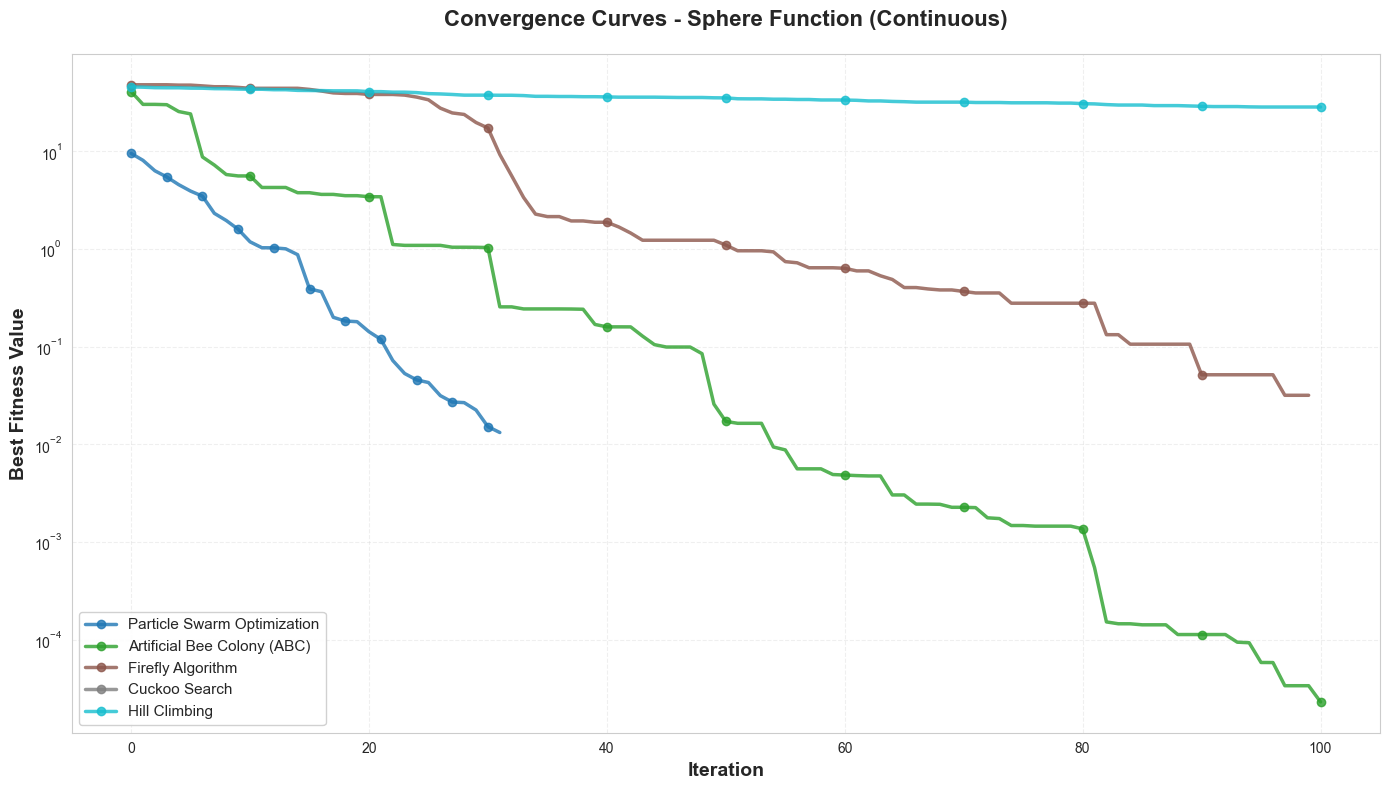

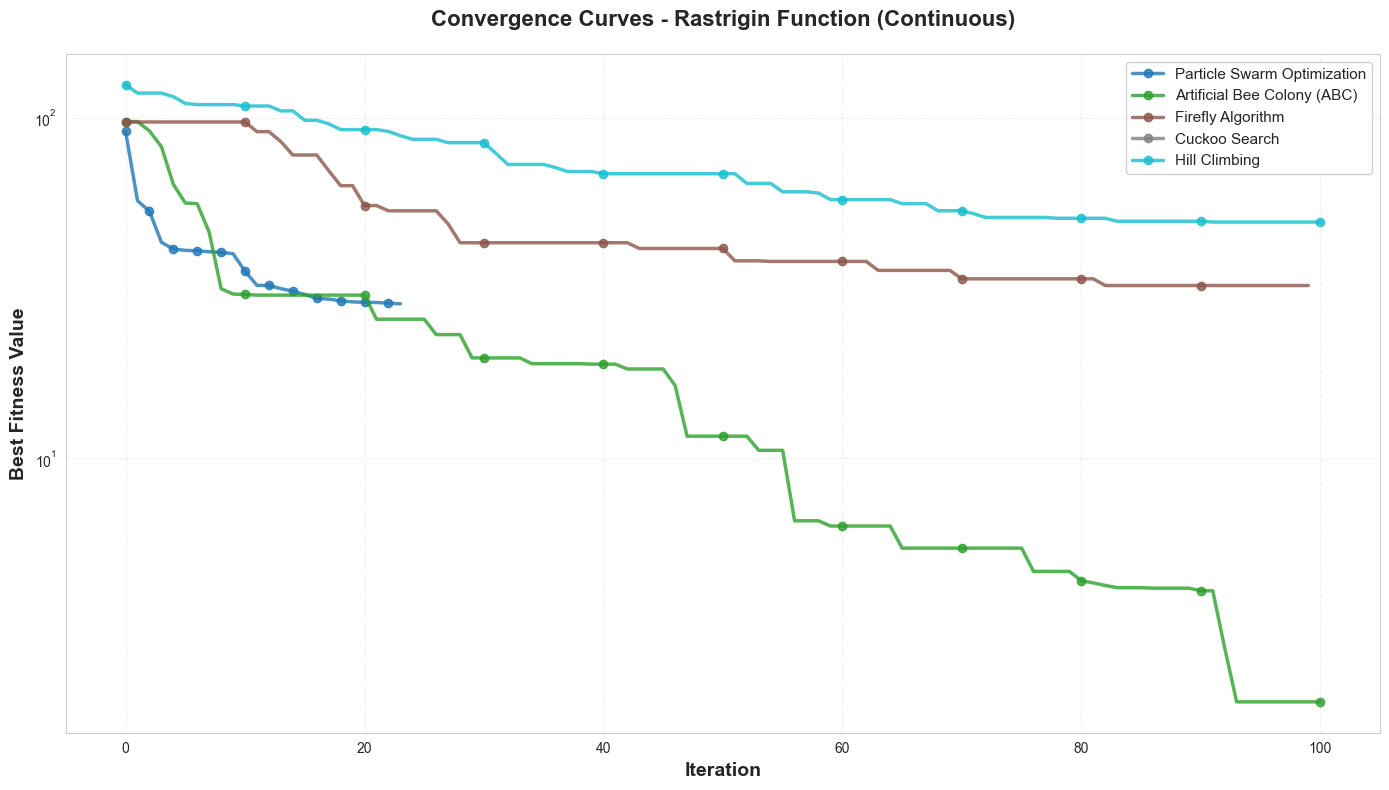

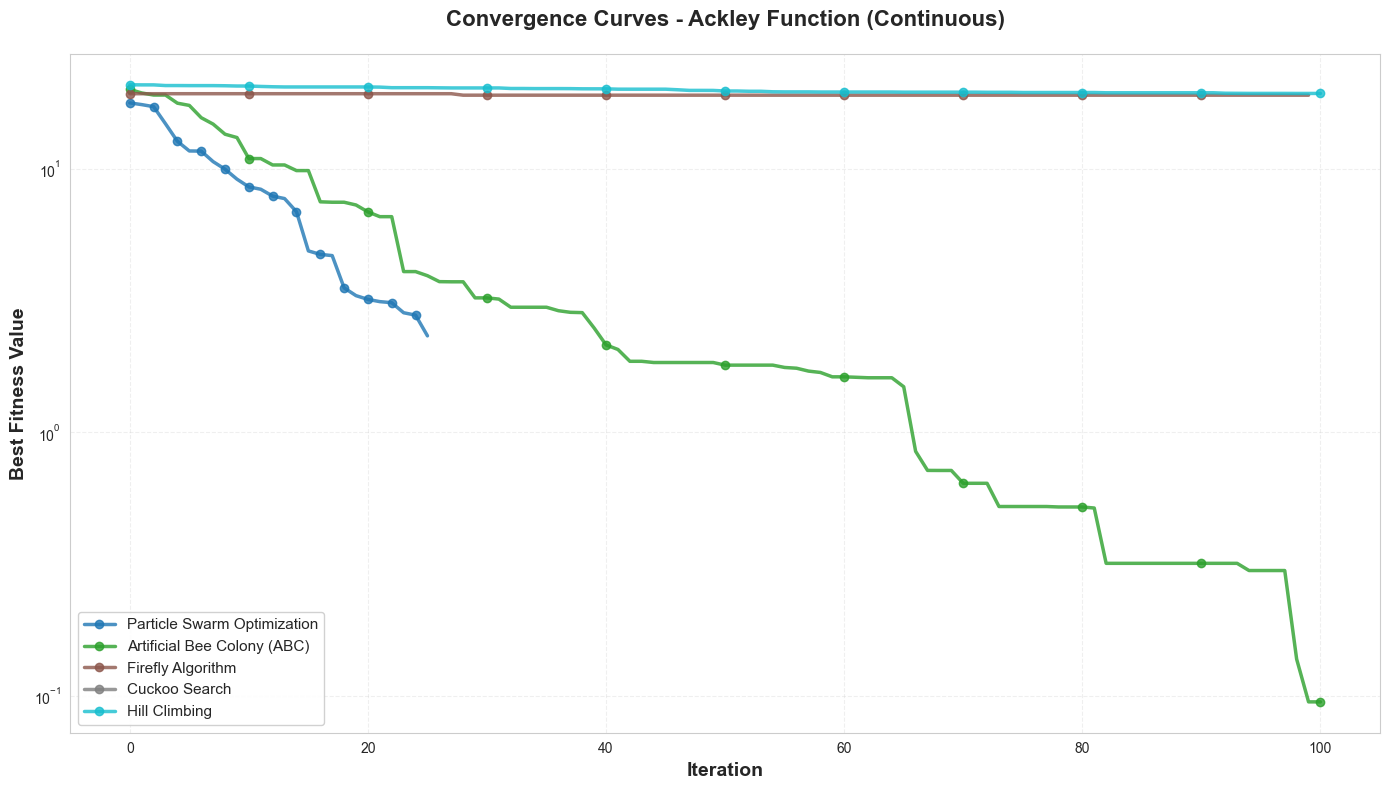

In [3]:
def plot_convergence_curves(results, problem_name, title_suffix=""):
    """
    Vẽ biểu đồ convergence curves cho một bài toán cụ thể
    """
    if problem_name not in results:
        print(f"Không tìm thấy bài toán {problem_name}")
        return
    
    problem_data = results[problem_name]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(problem_data)))
    
    for idx, (alg_name, alg_data) in enumerate(problem_data.items()):
        if 'best_run_convergence' in alg_data:
            convergence = alg_data['best_run_convergence']
            iterations = range(len(convergence))
            
            # Vẽ đường convergence
            ax.plot(iterations, convergence, 
                   label=alg_name, 
                   linewidth=2.5,
                   color=colors[idx],
                   marker='o',
                   markevery=max(1, len(convergence)//10),
                   markersize=6,
                   alpha=0.8)
    
    ax.set_xlabel('Iteration', fontsize=14, fontweight='bold')
    ax.set_ylabel('Best Fitness Value', fontsize=14, fontweight='bold')
    ax.set_title(f'Convergence Curves - {problem_name} {title_suffix}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='best', framealpha=0.9, fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_yscale('log')  # Sử dụng log scale để thấy rõ hơn
    
    plt.tight_layout()
    plt.show()

# Vẽ convergence curves cho tất cả các bài toán liên tục
if continuous_results:
    for problem in continuous_results.keys():
        plot_convergence_curves(continuous_results, problem, "(Continuous)")

# 2. Hiệu Suất So Sánh (Performance Comparison)

So sánh hiệu suất của các thuật toán dựa trên fitness, thời gian chạy và số lần đánh giá.

=== So sánh Fitness ===


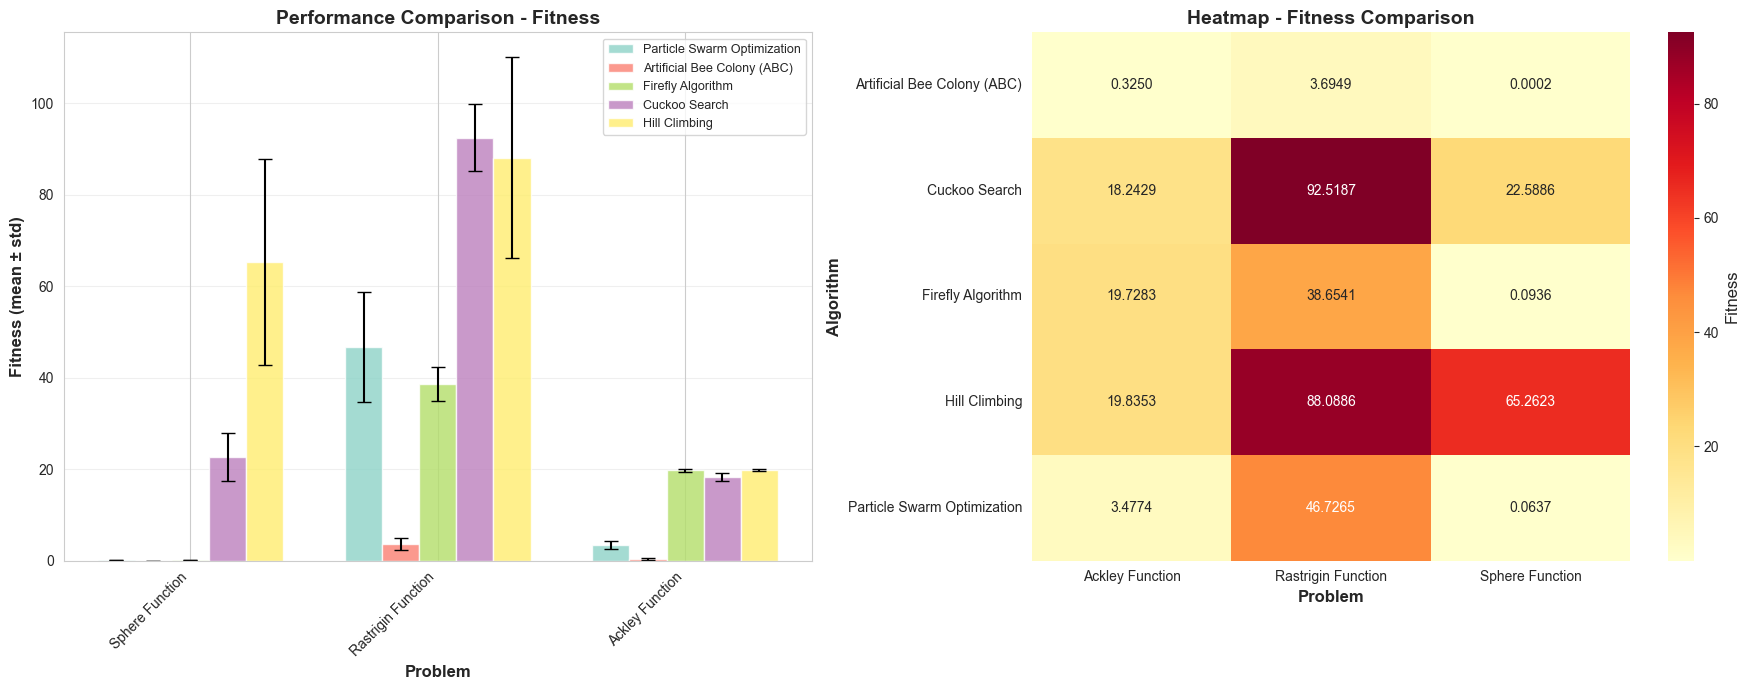

In [4]:
def plot_performance_comparison(results, metric='fitness'):
    """
    So sánh hiệu suất của các thuật toán dựa trên một metric cụ thể
    metric: 'fitness', 'time', 'evaluations'
    """
    if not results:
        print("Không có dữ liệu để vẽ")
        return
    
    # Chuẩn bị dữ liệu
    data = []
    for problem, algorithms in results.items():
        for alg_name, alg_data in algorithms.items():
            if metric in alg_data:
                data.append({
                    'Problem': problem,
                    'Algorithm': alg_name,
                    'Mean': alg_data[metric]['mean'],
                    'Std': alg_data[metric].get('std', 0),
                    'Min': alg_data[metric].get('min', alg_data[metric]['mean']),
                    'Max': alg_data[metric].get('max', alg_data[metric]['mean'])
                })
    
    df = pd.DataFrame(data)
    
    # Vẽ biểu đồ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Biểu đồ cột với error bars
    problems = df['Problem'].unique()
    x = np.arange(len(problems))
    width = 0.15
    
    algorithms = df['Algorithm'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))
    
    for idx, alg in enumerate(algorithms):
        alg_data = df[df['Algorithm'] == alg]
        means = [alg_data[alg_data['Problem'] == p]['Mean'].values[0] 
                if len(alg_data[alg_data['Problem'] == p]) > 0 else 0 
                for p in problems]
        stds = [alg_data[alg_data['Problem'] == p]['Std'].values[0] 
               if len(alg_data[alg_data['Problem'] == p]) > 0 else 0 
               for p in problems]
        
        ax1.bar(x + idx * width, means, width, 
               yerr=stds, 
               label=alg, 
               alpha=0.8,
               color=colors[idx],
               capsize=5)
    
    ax1.set_xlabel('Problem', fontsize=12, fontweight='bold')
    ax1.set_ylabel(f'{metric.capitalize()} (mean ± std)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Performance Comparison - {metric.capitalize()}', fontsize=14, fontweight='bold')
    ax1.set_xticks(x + width * (len(algorithms) - 1) / 2)
    ax1.set_xticklabels(problems, rotation=45, ha='right')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Heatmap
    pivot_df = df.pivot(index='Algorithm', columns='Problem', values='Mean')
    sns.heatmap(pivot_df, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax2, 
               cbar_kws={'label': f'{metric.capitalize()}'})
    ax2.set_title(f'Heatmap - {metric.capitalize()} Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Problem', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ so sánh fitness
if continuous_results:
    print("=== So sánh Fitness ===")
    plot_performance_comparison(continuous_results, 'fitness')

=== So sánh Thời gian ===


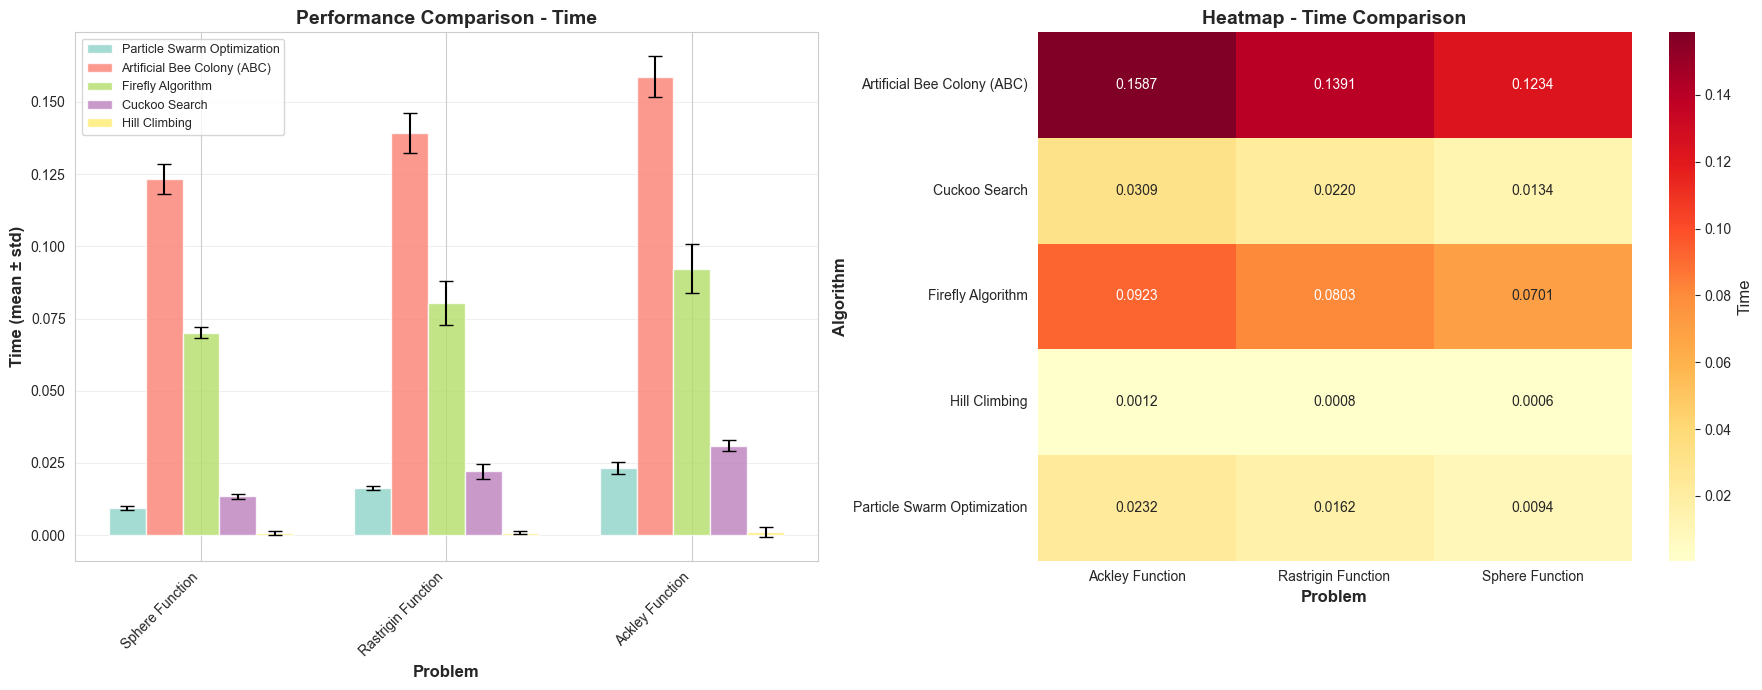

In [5]:
# Vẽ biểu đồ so sánh thời gian
if continuous_results:
    print("=== So sánh Thời gian ===")
    plot_performance_comparison(continuous_results, 'time')

C:\Users\trung\AppData\Local\Temp\ipykernel_16684\3500208237.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=problem_df, x='Algorithm', y='Value', ax=axes[idx], palette='Set2')
C:\Users\trung\AppData\Local\Temp\ipykernel_16684\3500208237.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(labels, rotation=45, ha='right')
C:\Users\trung\AppData\Local\Temp\ipykernel_16684\3500208237.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=problem_df, x='Algorithm', y='Value', ax=axes[idx], palette='Set2')
C:\Users\trung\AppData\Local\Temp\ipykernel_16684\3500208237.py:46:

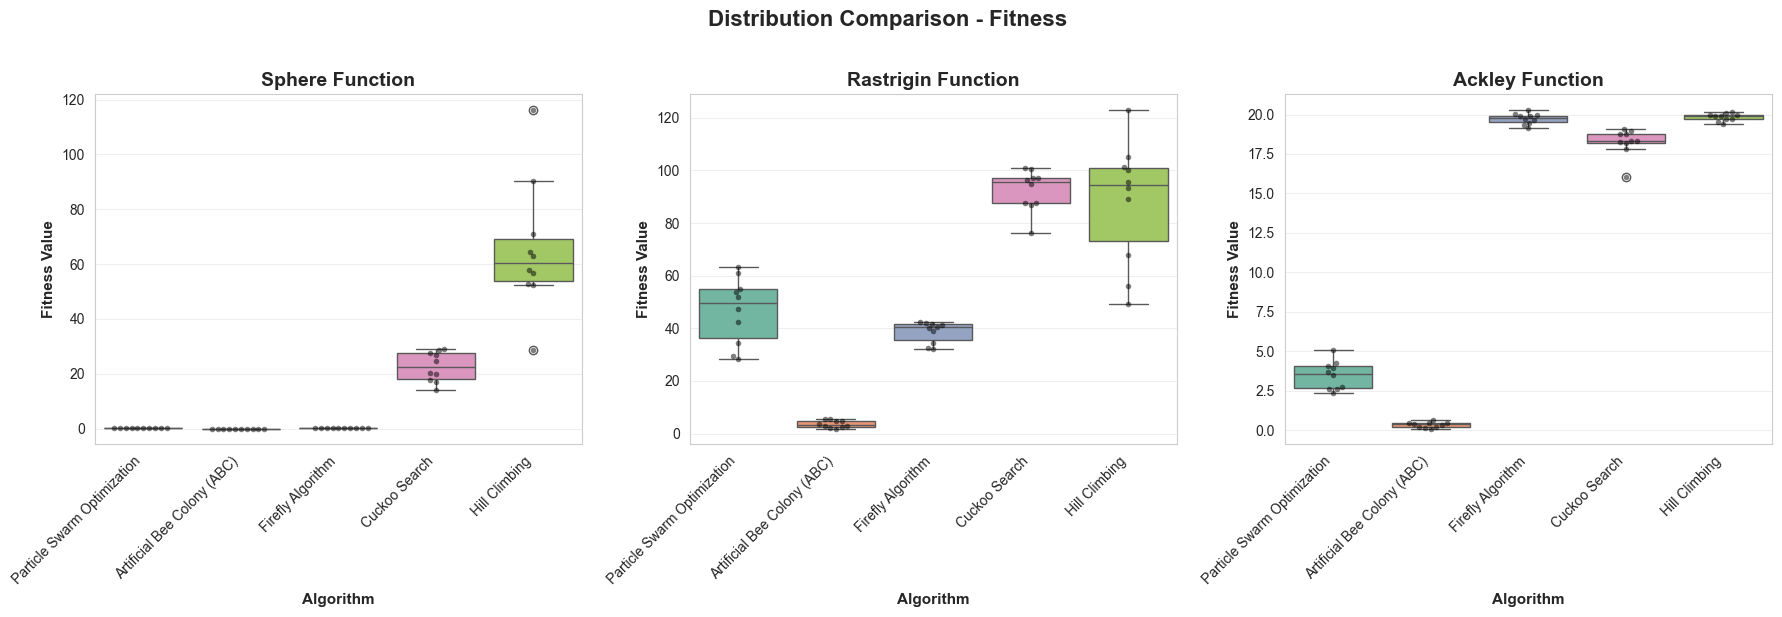

In [6]:
def plot_boxplot_comparison(results, metric='fitness'):
    """
    Vẽ boxplot để so sánh phân phối của các thuật toán
    """
    if not results:
        print("Không có dữ liệu để vẽ")
        return
    
    # Chuẩn bị dữ liệu
    data = []
    for problem, algorithms in results.items():
        for alg_name, alg_data in algorithms.items():
            if metric in alg_data and 'all_values' in alg_data[metric]:
                for value in alg_data[metric]['all_values']:
                    data.append({
                        'Problem': problem,
                        'Algorithm': alg_name,
                        'Value': value
                    })
    
    df = pd.DataFrame(data)
    
    # Vẽ biểu đồ
    problems = df['Problem'].unique()
    n_problems = len(problems)
    
    fig, axes = plt.subplots(1, n_problems, figsize=(6 * n_problems, 6))
    if n_problems == 1:
        axes = [axes]
    
    for idx, problem in enumerate(problems):
        problem_df = df[df['Problem'] == problem]
        
        sns.boxplot(data=problem_df, x='Algorithm', y='Value', ax=axes[idx], palette='Set2')
        sns.swarmplot(data=problem_df, x='Algorithm', y='Value', ax=axes[idx], 
                     color='black', alpha=0.5, size=4)
        
        axes[idx].set_title(f'{problem}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Algorithm', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(f'{metric.capitalize()} Value', fontsize=11, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Điều chỉnh labels
        labels = axes[idx].get_xticklabels()
        axes[idx].set_xticklabels(labels, rotation=45, ha='right')
    
    plt.suptitle(f'Distribution Comparison - {metric.capitalize()}', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

if continuous_results:
    plot_boxplot_comparison(continuous_results, 'fitness')

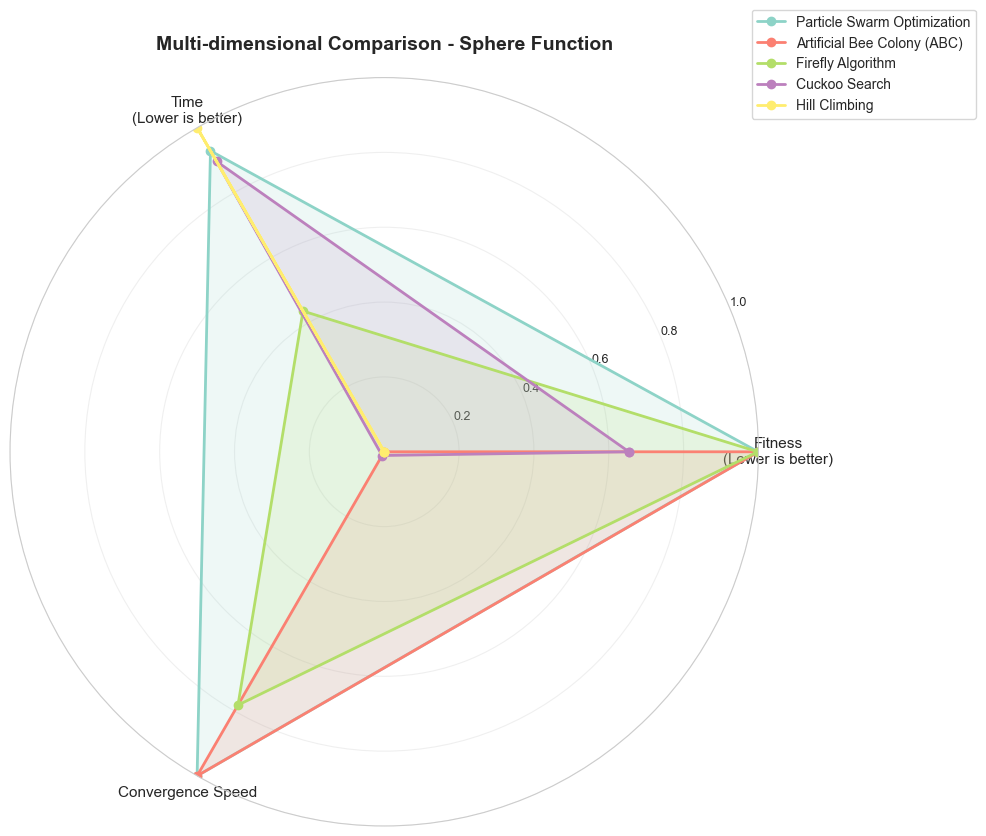

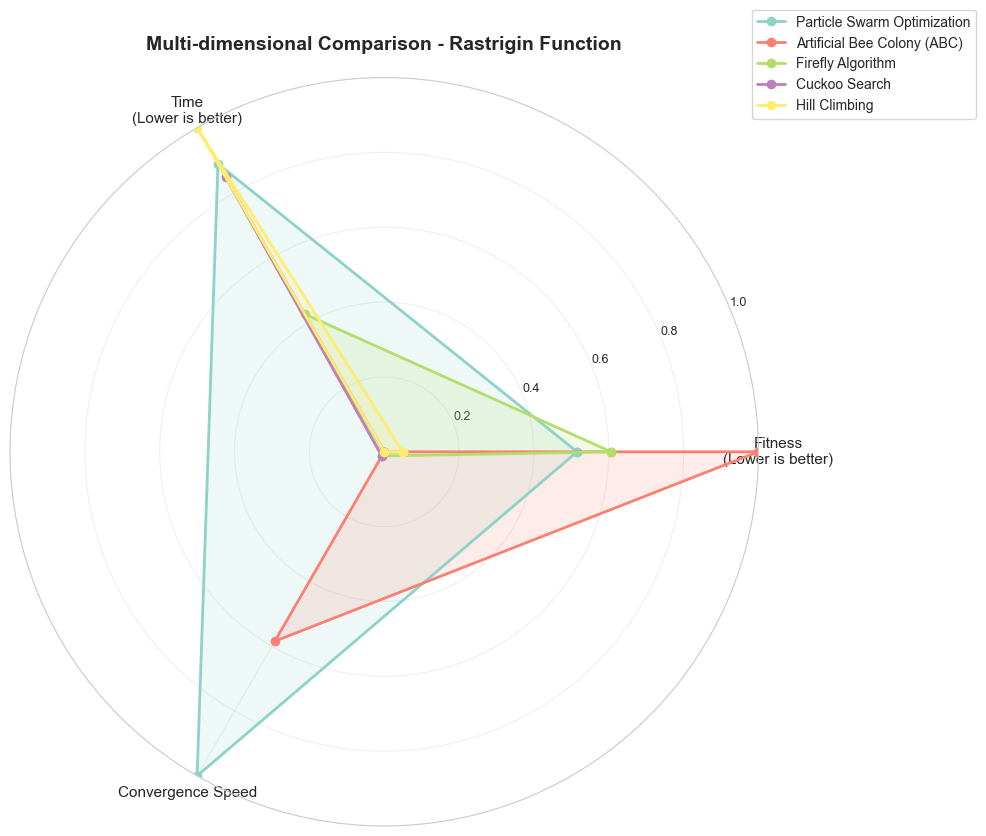

In [7]:
def plot_radar_chart(results, problem_name):
    """
    Vẽ biểu đồ radar để so sánh đa chiều các thuật toán
    """
    if problem_name not in results:
        print(f"Không tìm thấy bài toán {problem_name}")
        return
    
    problem_data = results[problem_name]
    algorithms = list(problem_data.keys())
    
    # Chuẩn bị metrics
    metrics = ['Fitness\n(Lower is better)', 'Time\n(Lower is better)', 'Convergence Speed']
    
    # Chuẩn hóa dữ liệu (0-1, 1 là tốt nhất)
    fitness_values = [problem_data[alg]['fitness']['mean'] for alg in algorithms]
    time_values = [problem_data[alg]['time']['mean'] for alg in algorithms]
    
    # Tính convergence speed (giảm 90% fitness trong bao nhiêu iterations)
    convergence_speeds = []
    for alg in algorithms:
        if 'best_run_convergence' in problem_data[alg] and len(problem_data[alg]['best_run_convergence']) > 0:
            conv = problem_data[alg]['best_run_convergence']
            initial = conv[0]
            target = initial * 0.1
            iterations_to_target = len(conv)
            for i, val in enumerate(conv):
                if val <= target:
                    iterations_to_target = i
                    break
            convergence_speeds.append(iterations_to_target)
        else:
            convergence_speeds.append(100)
    
    # Chuẩn hóa (đảo ngược để giá trị cao là tốt)
    fitness_norm = 1 - (np.array(fitness_values) - min(fitness_values)) / (max(fitness_values) - min(fitness_values) + 1e-10)
    time_norm = 1 - (np.array(time_values) - min(time_values)) / (max(time_values) - min(time_values) + 1e-10)
    speed_norm = 1 - (np.array(convergence_speeds) - min(convergence_speeds)) / (max(convergence_speeds) - min(convergence_speeds) + 1e-10)
    
    # Vẽ biểu đồ
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))
    
    for idx, alg in enumerate(algorithms):
        values = [fitness_norm[idx], time_norm[idx], speed_norm[idx]]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=alg, color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    ax.set_title(f'Multi-dimensional Comparison - {problem_name}', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Vẽ radar chart cho từng bài toán
if continuous_results:
    for problem in list(continuous_results.keys())[:2]:  # Vẽ 2 bài toán đầu tiên
        plot_radar_chart(continuous_results, problem)

# 3. Phân Tích Độ Nhạy Tham Số (Parameter Sensitivity Analysis)

Phân tích ảnh hưởng của tham số đến hiệu suất thuật toán.

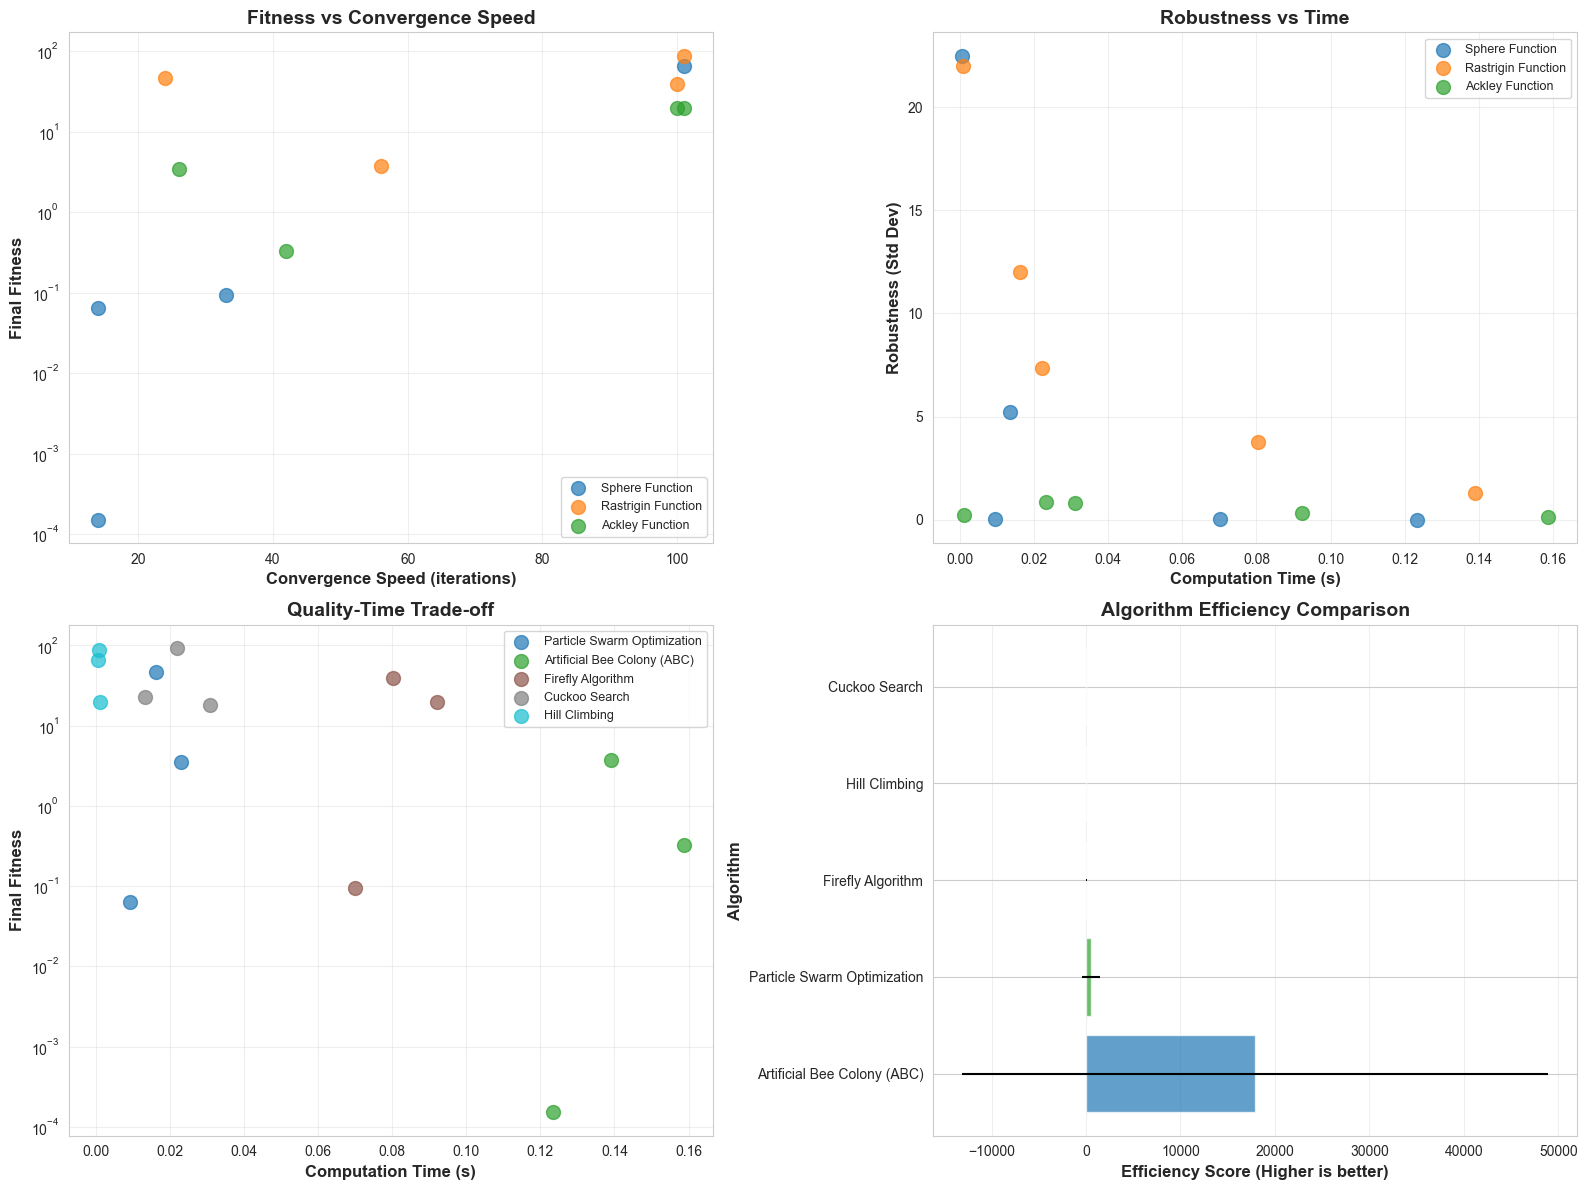

In [8]:
def plot_parameter_sensitivity(results):
    """
    Phân tích độ nhạy của các tham số với fitness
    """
    if not results:
        print("Không có dữ liệu để vẽ")
        return
    
    # Chuẩn bị dữ liệu
    data = []
    for problem, algorithms in results.items():
        for alg_name, alg_data in algorithms.items():
            data.append({
                'Problem': problem,
                'Algorithm': alg_name,
                'Convergence Speed': alg_data.get('convergence_speed', 0),
                'Fitness': alg_data['fitness']['mean'],
                'Time': alg_data['time']['mean'],
                'Robustness': alg_data.get('robustness', {}).get('std', 0)
            })
    
    df = pd.DataFrame(data)
    
    # Vẽ biểu đồ
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Fitness vs Convergence Speed
    for problem in df['Problem'].unique():
        problem_df = df[df['Problem'] == problem]
        axes[0, 0].scatter(problem_df['Convergence Speed'], problem_df['Fitness'], 
                          label=problem, alpha=0.7, s=100)
    
    axes[0, 0].set_xlabel('Convergence Speed (iterations)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Final Fitness', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Fitness vs Convergence Speed', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # 2. Robustness vs Time
    for problem in df['Problem'].unique():
        problem_df = df[df['Problem'] == problem]
        axes[0, 1].scatter(problem_df['Time'], problem_df['Robustness'], 
                          label=problem, alpha=0.7, s=100)
    
    axes[0, 1].set_xlabel('Computation Time (s)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Robustness (Std Dev)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Robustness vs Time', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Fitness vs Time (Trade-off)
    algorithms = df['Algorithm'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))
    
    for idx, alg in enumerate(algorithms):
        alg_df = df[df['Algorithm'] == alg]
        axes[1, 0].scatter(alg_df['Time'], alg_df['Fitness'], 
                          label=alg, alpha=0.7, s=100, color=colors[idx])
    
    axes[1, 0].set_xlabel('Computation Time (s)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Final Fitness', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Quality-Time Trade-off', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=9, loc='best')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # 4. Efficiency Score (Fitness/Time)
    df['Efficiency'] = 1 / (df['Fitness'] * df['Time'] + 1e-10)
    
    efficiency_data = df.groupby('Algorithm')['Efficiency'].agg(['mean', 'std']).reset_index()
    efficiency_data = efficiency_data.sort_values('mean', ascending=False)
    
    bars = axes[1, 1].barh(efficiency_data['Algorithm'], efficiency_data['mean'], 
                           xerr=efficiency_data['std'], alpha=0.7, color=colors[:len(efficiency_data)])
    axes[1, 1].set_xlabel('Efficiency Score (Higher is better)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Algorithm Efficiency Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

if continuous_results:
    plot_parameter_sensitivity(continuous_results)

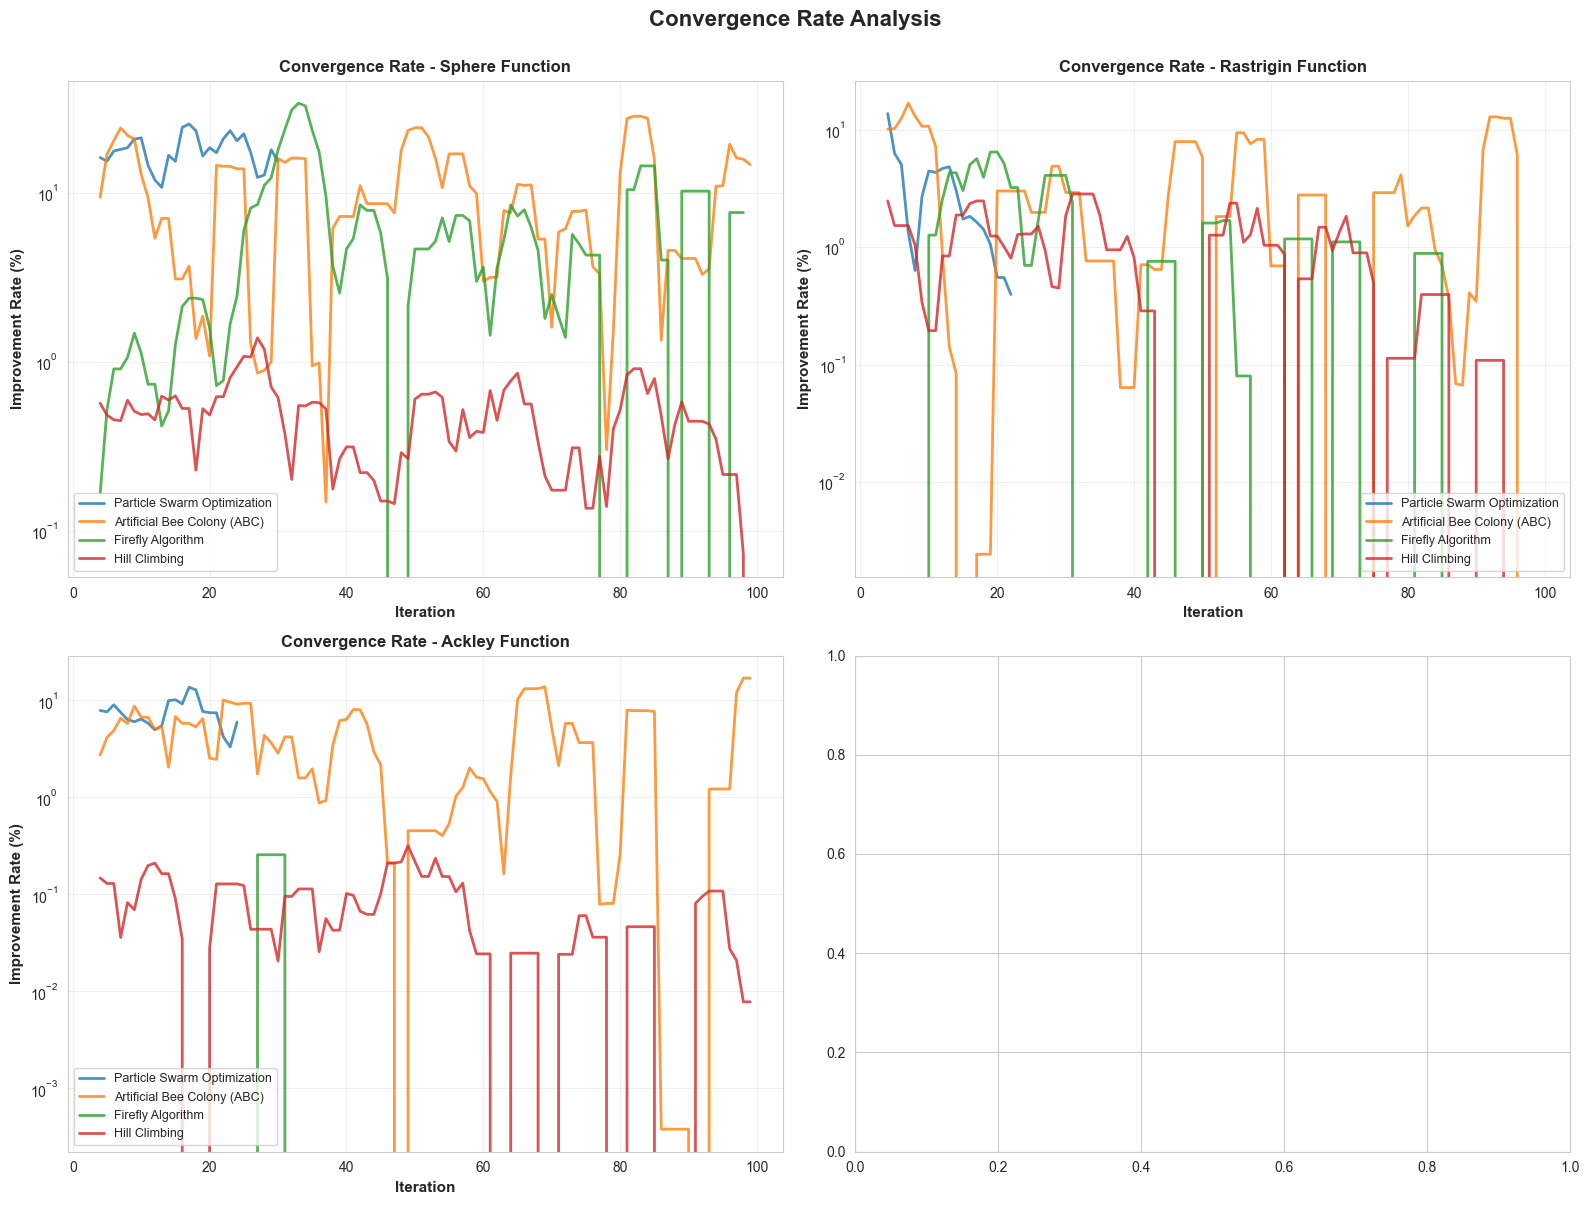

In [9]:
def plot_convergence_rate_analysis(results):
    """
    Phân tích tốc độ hội tụ của các thuật toán
    """
    if not results:
        print("Không có dữ liệu để vẽ")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for idx, (problem, algorithms) in enumerate(list(results.items())[:4]):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        for alg_name, alg_data in algorithms.items():
            if 'best_run_convergence' not in alg_data:
                continue
                
            convergence = np.array(alg_data['best_run_convergence'])
            
            # Tính improvement rate (% cải thiện giữa các iteration)
            if len(convergence) > 1:
                improvement_rate = []
                for i in range(1, len(convergence)):
                    if convergence[i-1] > 0:
                        rate = abs((convergence[i] - convergence[i-1]) / convergence[i-1] * 100)
                        improvement_rate.append(rate)
                    else:
                        improvement_rate.append(0)
                
                # Làm mượt bằng moving average
                window = 5
                if len(improvement_rate) >= window:
                    smoothed = np.convolve(improvement_rate, np.ones(window)/window, mode='valid')
                    iterations = range(window-1, len(improvement_rate))
                    ax.plot(iterations, smoothed, label=alg_name, linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Iteration', fontsize=11, fontweight='bold')
        ax.set_ylabel('Improvement Rate (%)', fontsize=11, fontweight='bold')
        ax.set_title(f'Convergence Rate - {problem}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    plt.suptitle('Convergence Rate Analysis', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

if continuous_results:
    plot_convergence_rate_analysis(continuous_results)

# 4. Biểu Đồ Bề Mặt 3D (Advanced 3D Surface Visualization)

Mô tả trực quan bối cảnh của hàm mục tiêu (Objective Function Landscape).

In [10]:
# Định nghĩa các hàm benchmark để vẽ 3D surface

def sphere_function(x, y):
    """Sphere Function: f(x,y) = x^2 + y^2"""
    return x**2 + y**2

def rastrigin_function(x, y):
    """Rastrigin Function"""
    A = 10
    return 2*A + (x**2 - A*np.cos(2*np.pi*x)) + (y**2 - A*np.cos(2*np.pi*y))

def ackley_function(x, y):
    """Ackley Function"""
    return -20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.e + 20


# Dictionary mapping tên hàm đến function
BENCHMARK_FUNCTIONS = {
    'Sphere Function': (sphere_function, (-5, 5)),
    'Rastrigin Function': (rastrigin_function, (-5.12, 5.12)),
    'Ackley Function': (ackley_function, (-5, 5)),
}

print("Đã định nghĩa các hàm benchmark!")

Đã định nghĩa các hàm benchmark!


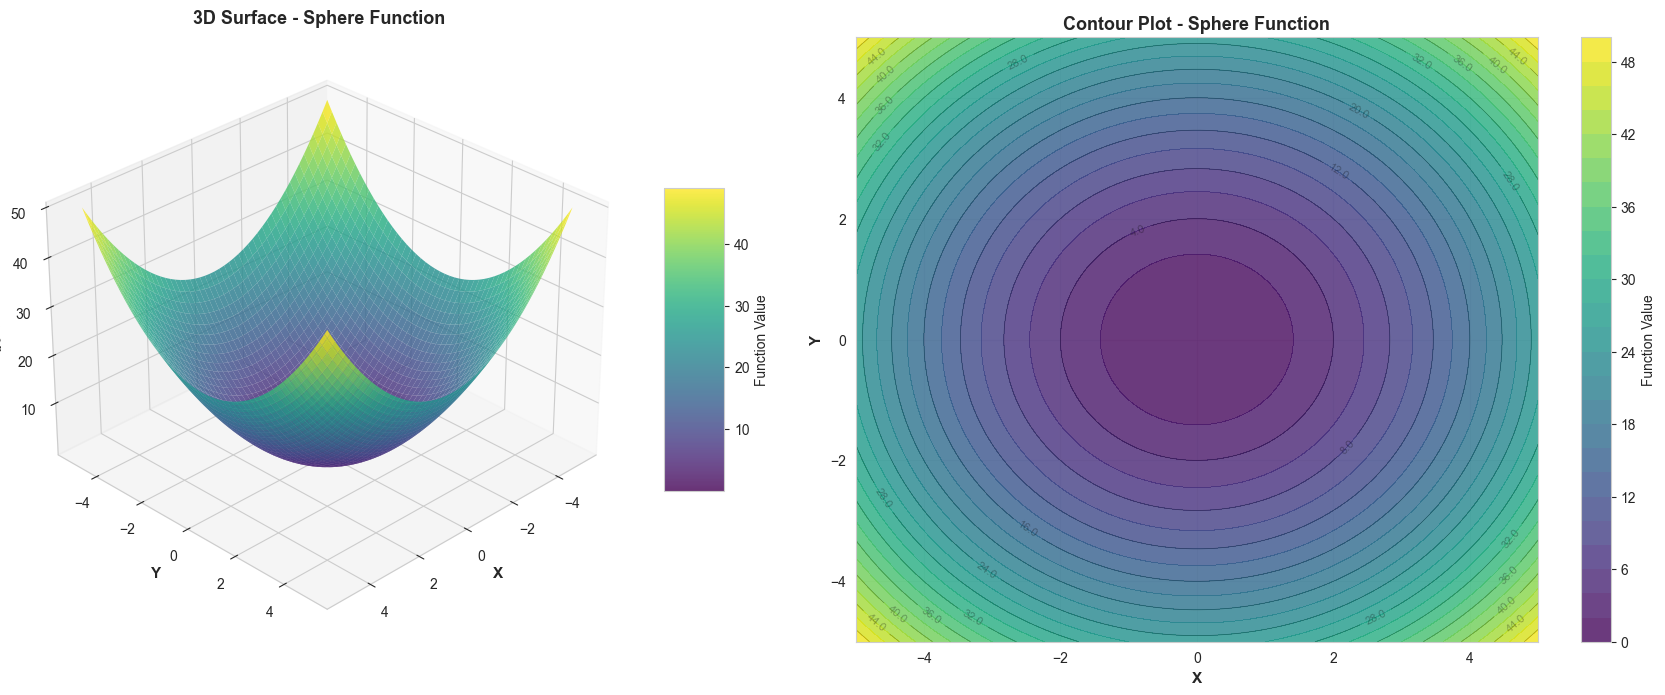

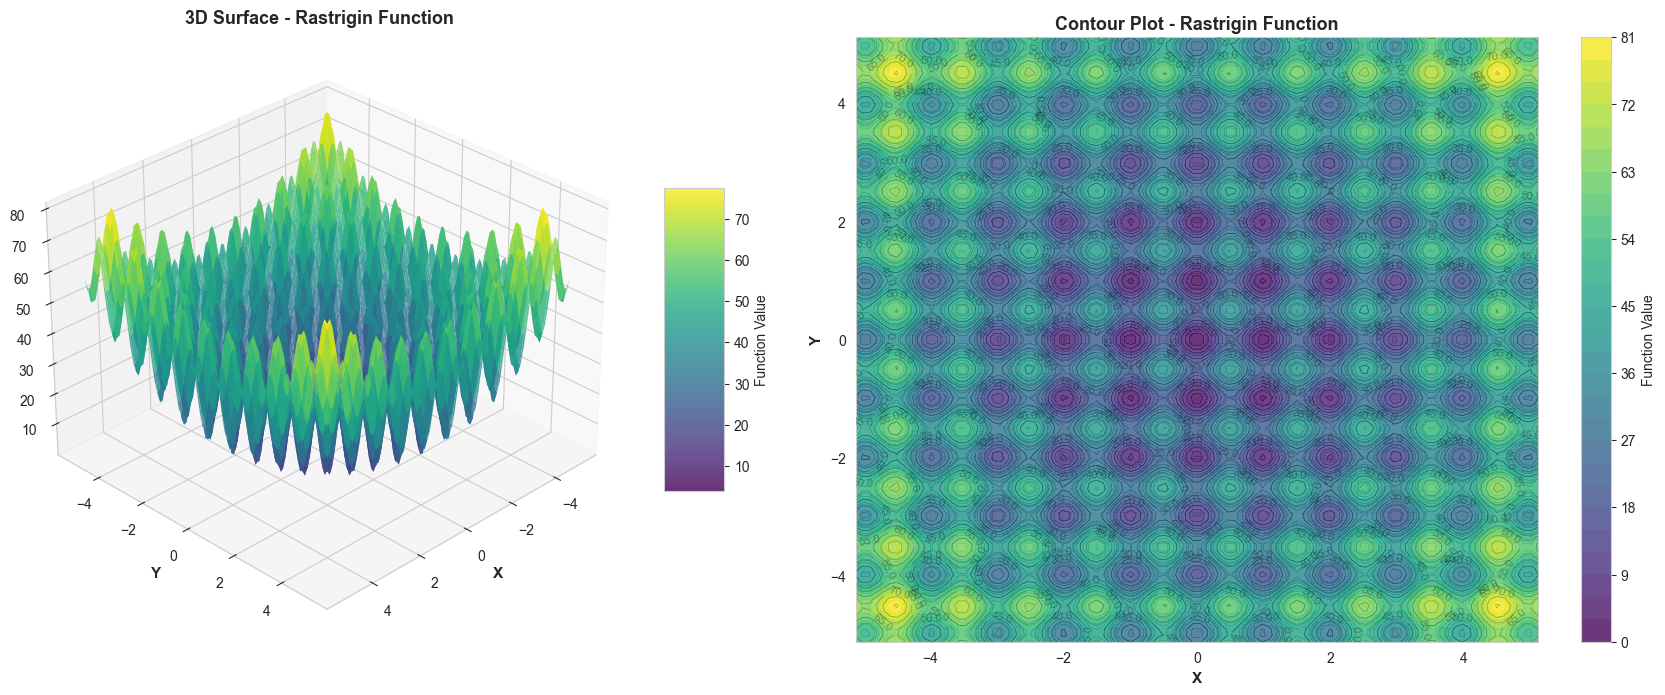

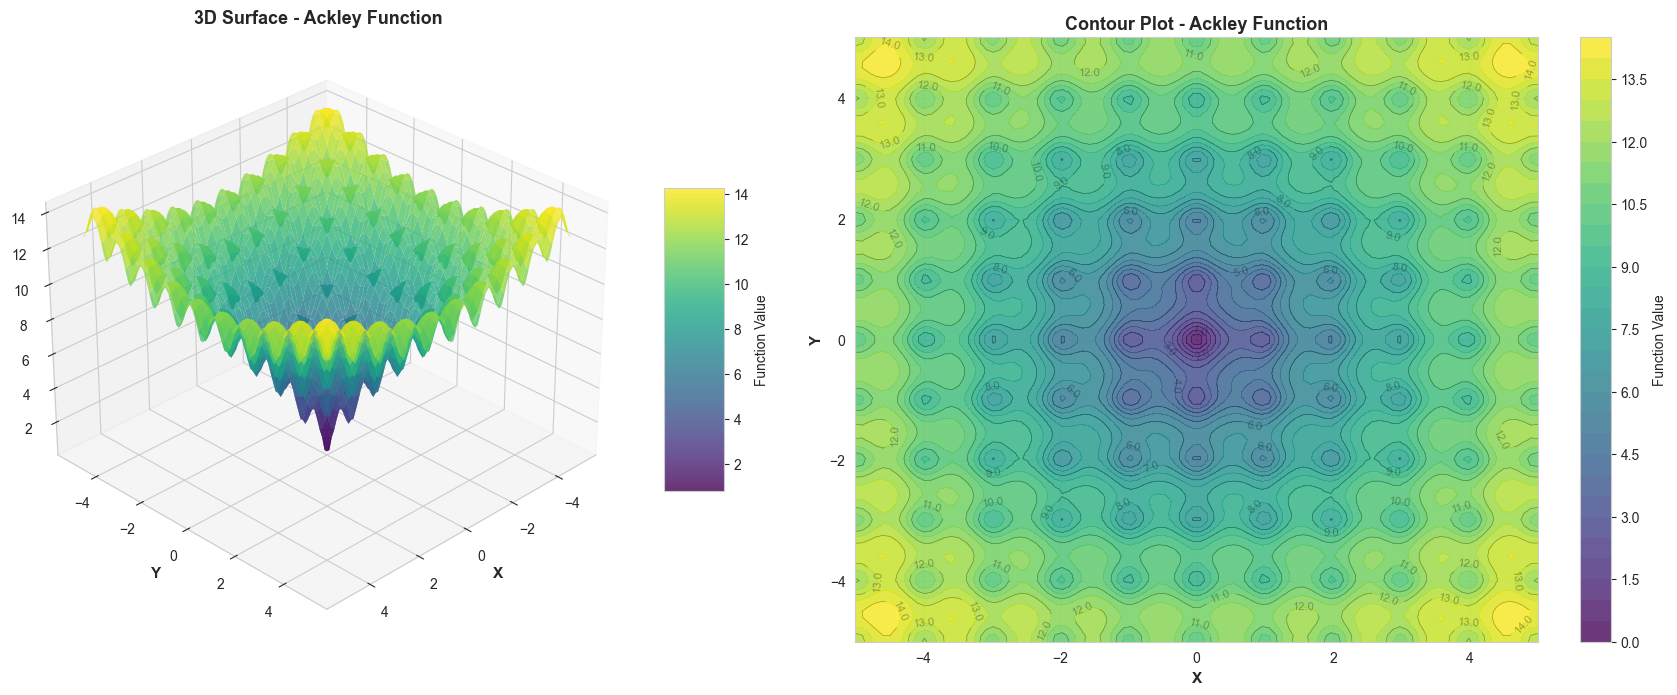

In [11]:
def plot_3d_surface(function_name, func, bounds, resolution=100):
    """
    Vẽ bề mặt 3D của hàm mục tiêu
    """
    x = np.linspace(bounds[0], bounds[1], resolution)
    y = np.linspace(bounds[0], bounds[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    # Tạo figure với 2 subplots
    fig = plt.figure(figsize=(18, 7))
    
    # Subplot 1: Surface plot
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.8, 
                           linewidth=0, antialiased=True, edgecolor='none')
    
    ax1.set_xlabel('X', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Y', fontsize=11, fontweight='bold')
    ax1.set_zlabel('f(X, Y)', fontsize=11, fontweight='bold')
    ax1.set_title(f'3D Surface - {function_name}', fontsize=13, fontweight='bold', pad=10)
    ax1.view_init(elev=30, azim=45)
    
    # Thêm colorbar
    cbar1 = fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    cbar1.set_label('Function Value', fontsize=10)
    
    # Subplot 2: Contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X, Y, Z, levels=30, cmap=cm.viridis, alpha=0.8)
    contour_lines = ax2.contour(X, Y, Z, levels=15, colors='black', alpha=0.3, linewidths=0.5)
    ax2.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f')
    
    ax2.set_xlabel('X', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Y', fontsize=11, fontweight='bold')
    ax2.set_title(f'Contour Plot - {function_name}', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Thêm colorbar cho contour
    cbar2 = fig.colorbar(contour, ax=ax2)
    cbar2.set_label('Function Value', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Vẽ 3D surface cho các hàm benchmark
for func_name, (func, bounds) in list(BENCHMARK_FUNCTIONS.items())[:3]:
    plot_3d_surface(func_name, func, bounds)

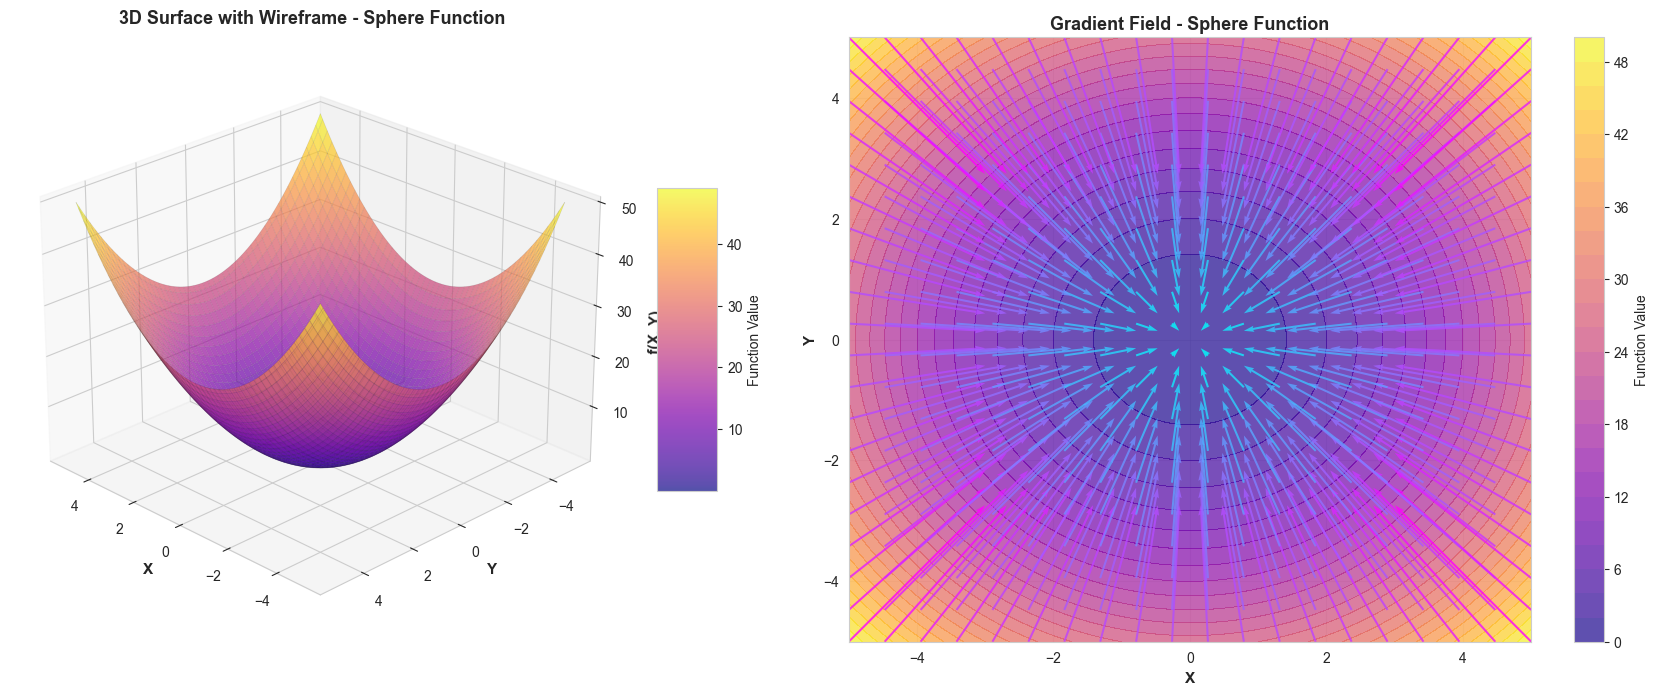

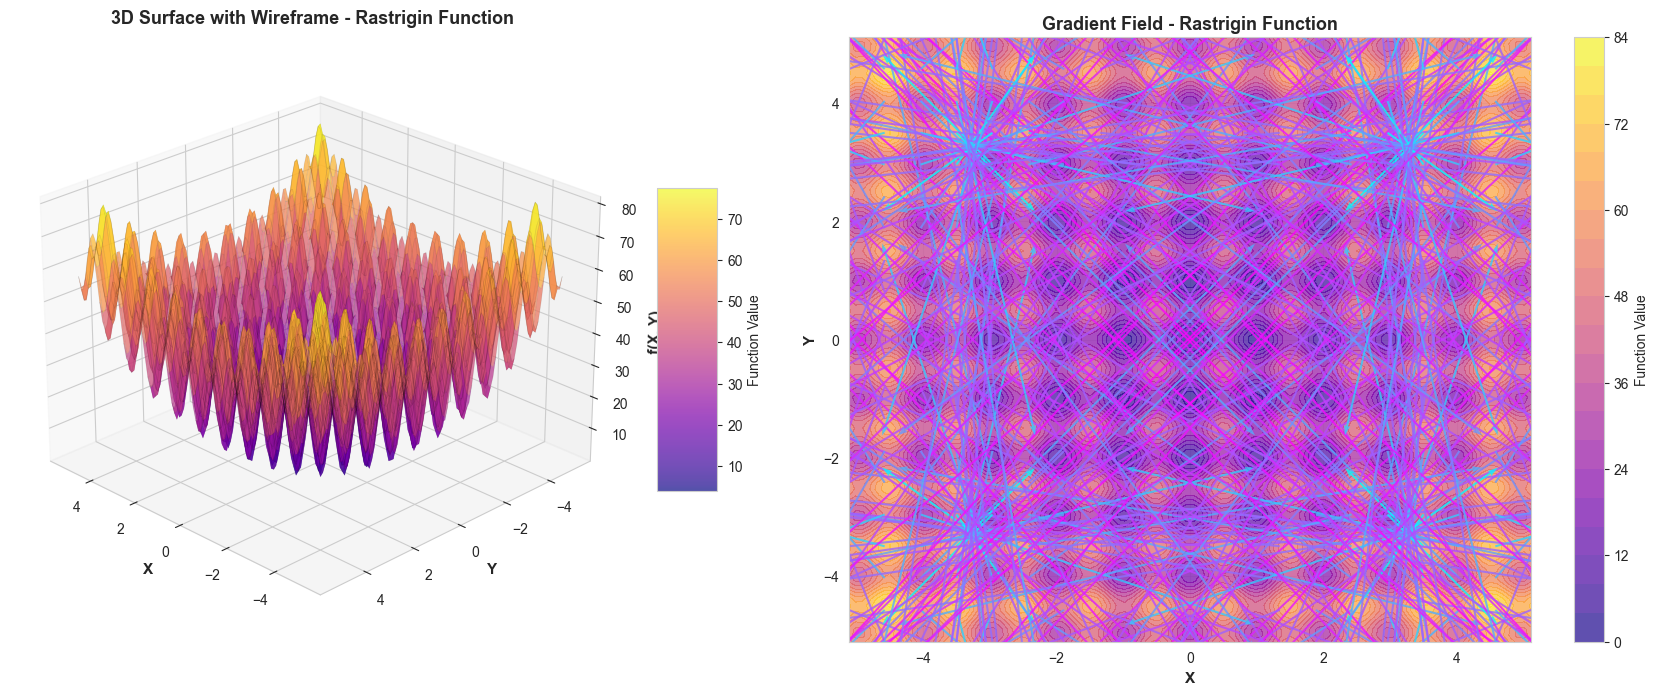

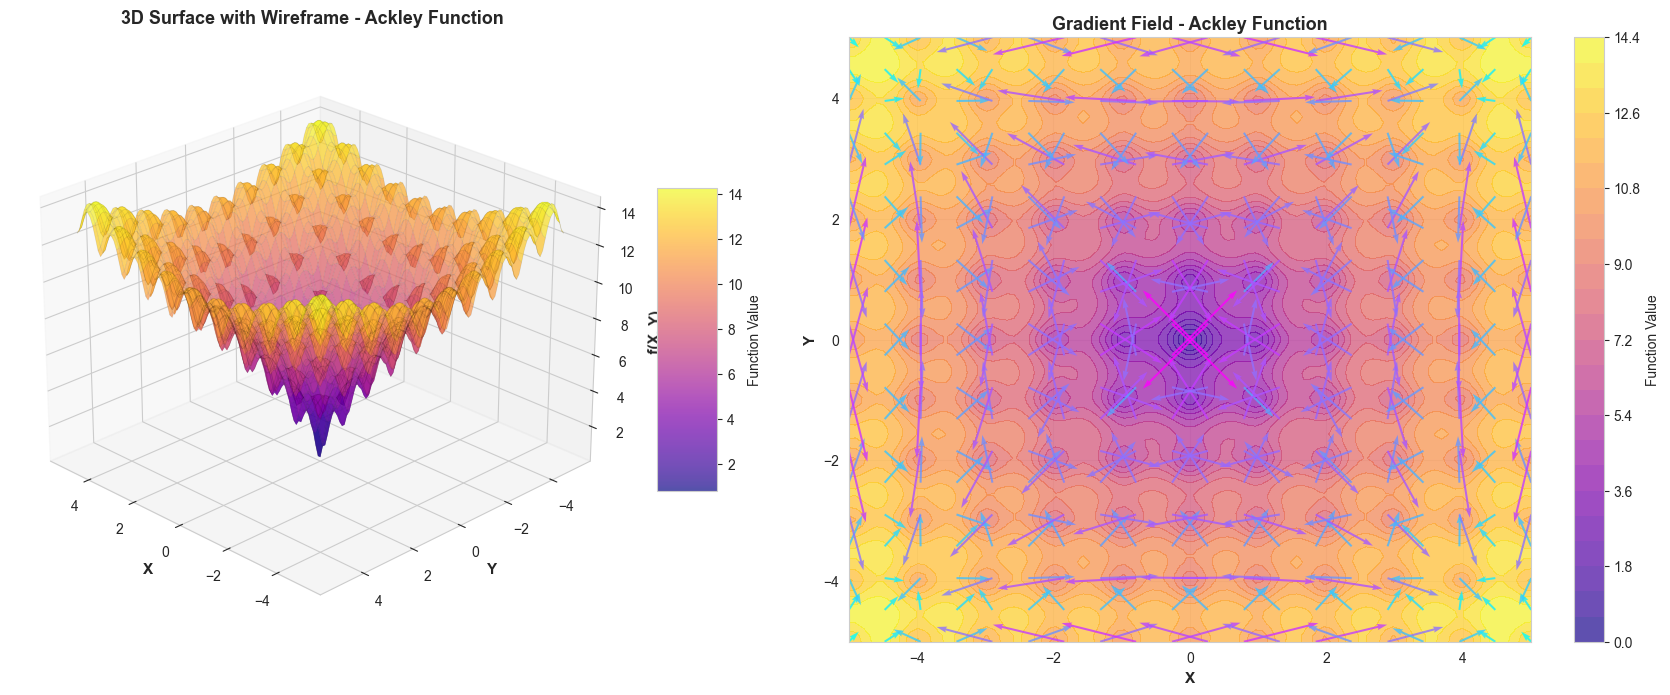

In [12]:
def plot_3d_with_gradient(function_name, func, bounds, resolution=100):
    """
    Vẽ bề mặt 3D kèm gradient vector field
    """
    x = np.linspace(bounds[0], bounds[1], resolution)
    y = np.linspace(bounds[0], bounds[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    fig = plt.figure(figsize=(18, 7))
    
    # Subplot 1: 3D Surface with wireframe
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Vẽ surface
    surf = ax1.plot_surface(X, Y, Z, cmap=cm.plasma, alpha=0.7,
                           linewidth=0, antialiased=True)
    
    # Vẽ wireframe overlay
    ax1.plot_wireframe(X, Y, Z, color='black', alpha=0.1, linewidth=0.5)
    
    ax1.set_xlabel('X', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Y', fontsize=11, fontweight='bold')
    ax1.set_zlabel('f(X, Y)', fontsize=11, fontweight='bold')
    ax1.set_title(f'3D Surface with Wireframe - {function_name}', 
                 fontsize=13, fontweight='bold', pad=10)
    ax1.view_init(elev=25, azim=135)
    
    cbar1 = fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    cbar1.set_label('Function Value', fontsize=10)
    
    # Subplot 2: Gradient field
    ax2 = fig.add_subplot(122)
    
    # Tính gradient (numerical)
    step = (bounds[1] - bounds[0]) / resolution
    x_grad = np.linspace(bounds[0], bounds[1], 20)
    y_grad = np.linspace(bounds[0], bounds[1], 20)
    X_grad, Y_grad = np.meshgrid(x_grad, y_grad)
    
    # Tính gradient bằng finite difference
    dx = np.zeros_like(X_grad)
    dy = np.zeros_like(Y_grad)
    
    for i in range(X_grad.shape[0]):
        for j in range(X_grad.shape[1]):
            x_val = X_grad[i, j]
            y_val = Y_grad[i, j]
            h = 0.01
            dx[i, j] = (func(x_val + h, y_val) - func(x_val - h, y_val)) / (2 * h)
            dy[i, j] = (func(x_val, y_val + h) - func(x_val, y_val - h)) / (2 * h)
    
    # Vẽ contour
    contour = ax2.contourf(X, Y, Z, levels=25, cmap=cm.plasma, alpha=0.7)
    
    # Vẽ gradient vectors
    magnitude = np.sqrt(dx**2 + dy**2)
    ax2.quiver(X_grad, Y_grad, -dx, -dy, magnitude, 
              cmap=cm.cool, alpha=0.8, scale=50, width=0.003)
    
    ax2.set_xlabel('X', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Y', fontsize=11, fontweight='bold')
    ax2.set_title(f'Gradient Field - {function_name}', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    cbar2 = fig.colorbar(contour, ax=ax2)
    cbar2.set_label('Function Value', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Vẽ 3D với gradient
for func_name, (func, bounds) in list(BENCHMARK_FUNCTIONS.items())[:3]:
    plot_3d_with_gradient(func_name, func, bounds)

# 5. Phân Tích Tổng Hợp (Comprehensive Analysis)

Tổng hợp và so sánh tất cả các khía cạnh của thuật toán.

C:\Users\trung\AppData\Roaming\Python\Python311\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\trung\AppData\Roaming\Python\Python311\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


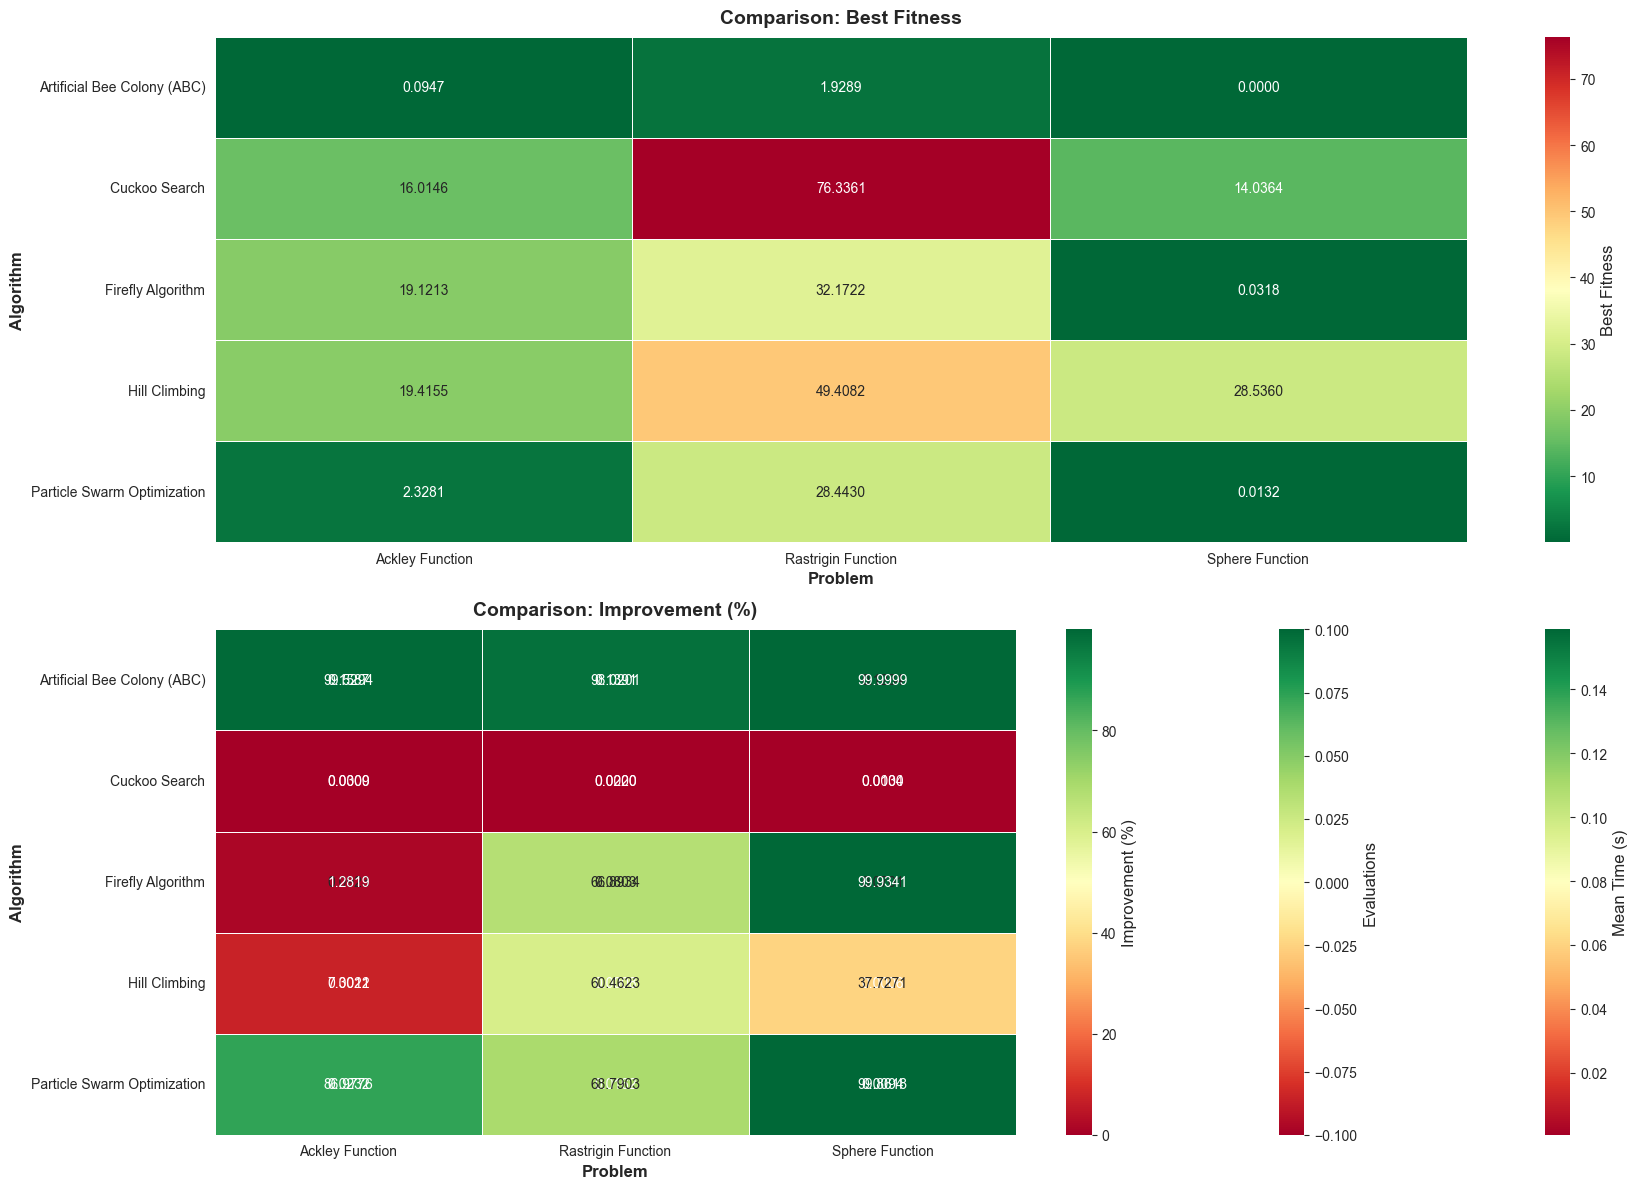


COMPREHENSIVE PERFORMANCE SUMMARY

Sphere Function:
--------------------------------------------------------------------------------------------------------------------------------------------
 Best Fitness  Mean Fitness  Std Fitness  Mean Time (s)         Problem                   Algorithm  Evaluations  Improvement (%)
     0.000023      0.000151     0.000097       0.123351 Sphere Function Artificial Bee Colony (ABC)          NaN        99.999944
     0.013219      0.063714     0.038139       0.009395 Sphere Function Particle Swarm Optimization          NaN        99.861751
     0.031801      0.093593     0.055200       0.070079 Sphere Function           Firefly Algorithm          NaN        99.934052
    14.036401     22.588552     5.211046       0.013389 Sphere Function               Cuckoo Search          NaN         0.000000
    28.535958     65.262307    22.494874       0.000635 Sphere Function               Hill Climbing          NaN        37.727072

Rastrigin Function:
-----

In [13]:
def create_comprehensive_summary(results):
    """
    Tạo bảng tổng hợp so sánh toàn diện
    """
    if not results:
        print("Không có dữ liệu để tạo summary")
        return
    
    # Chuẩn bị dữ liệu
    summary_data = []
    
    for problem, algorithms in results.items():
        for alg_name, alg_data in algorithms.items():
            row = {
                'Best Fitness': alg_data['fitness']['min'],
                'Mean Fitness': alg_data['fitness']['mean'],
                'Std Fitness': alg_data['fitness']['std'],
                'Mean Time (s)': alg_data['time']['mean'],
                'Problem': problem,
                'Algorithm': alg_name,
                'Evaluations': alg_data.get('evaluations', {}).get('mean', np.nan)
            }
            
            # Tính convergence speed
            if 'best_run_convergence' in alg_data and len(alg_data['best_run_convergence']) > 0:
                conv = alg_data['best_run_convergence']
                initial = conv[0]
                final = conv[-1]
                improvement = (initial - final) / initial * 100 if initial != 0 else 0
                row['Improvement (%)'] = improvement
            else:
                row['Improvement (%)'] = 0
            
            summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    
    # Vẽ bảng so sánh
    fig, axes = plt.subplots(2, 1, figsize=(18, 12))
    
    # Pivot table cho mỗi metric
    metrics = ['Best Fitness', 'Mean Time (s)', 'Evaluations', 'Improvement (%)']
    
    for idx, metric in enumerate(metrics):
        pivot = df.pivot(index='Algorithm', columns='Problem', values=metric)
        
        if idx == 0:
            ax = axes[0]
        else:
            ax = axes[1]
        
        sns.heatmap(pivot, annot=True, fmt='.4f', cmap='RdYlGn_r' if metric == 'Best Fitness' else 'RdYlGn', 
                   ax=ax, cbar_kws={'label': metric}, linewidths=0.5)
        ax.set_title(f'Comparison: {metric}', fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Problem', fontsize=12, fontweight='bold')
        ax.set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # In bảng summary
    print("\n" + "="*140)
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print("="*140)
    
    for problem in df['Problem'].unique():
        print(f"\n{problem}:")
        print("-" * 140)
        problem_df = df[df['Problem'] == problem].sort_values('Best Fitness')
        print(problem_df.to_string(index=False))
    
    print("\n" + "="*140)
    
    return df

# Tạo summary
if continuous_results:
    summary_df = create_comprehensive_summary(continuous_results)

C:\Users\trung\AppData\Local\Temp\ipykernel_16684\1963301715.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=problem_df, x='Algorithm', y='Fitness',
C:\Users\trung\AppData\Local\Temp\ipykernel_16684\1963301715.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, idx].set_xticklabels(labels, rotation=45, ha='right')
C:\Users\trung\AppData\Local\Temp\ipykernel_16684\1963301715.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=problem_df, x='Algorithm', y='Fitness',
C:\Users\trung\AppData\Local\Temp\ipykernel_16684\1963301715.py:42: UserWarning: set_ticklabels() should only be u

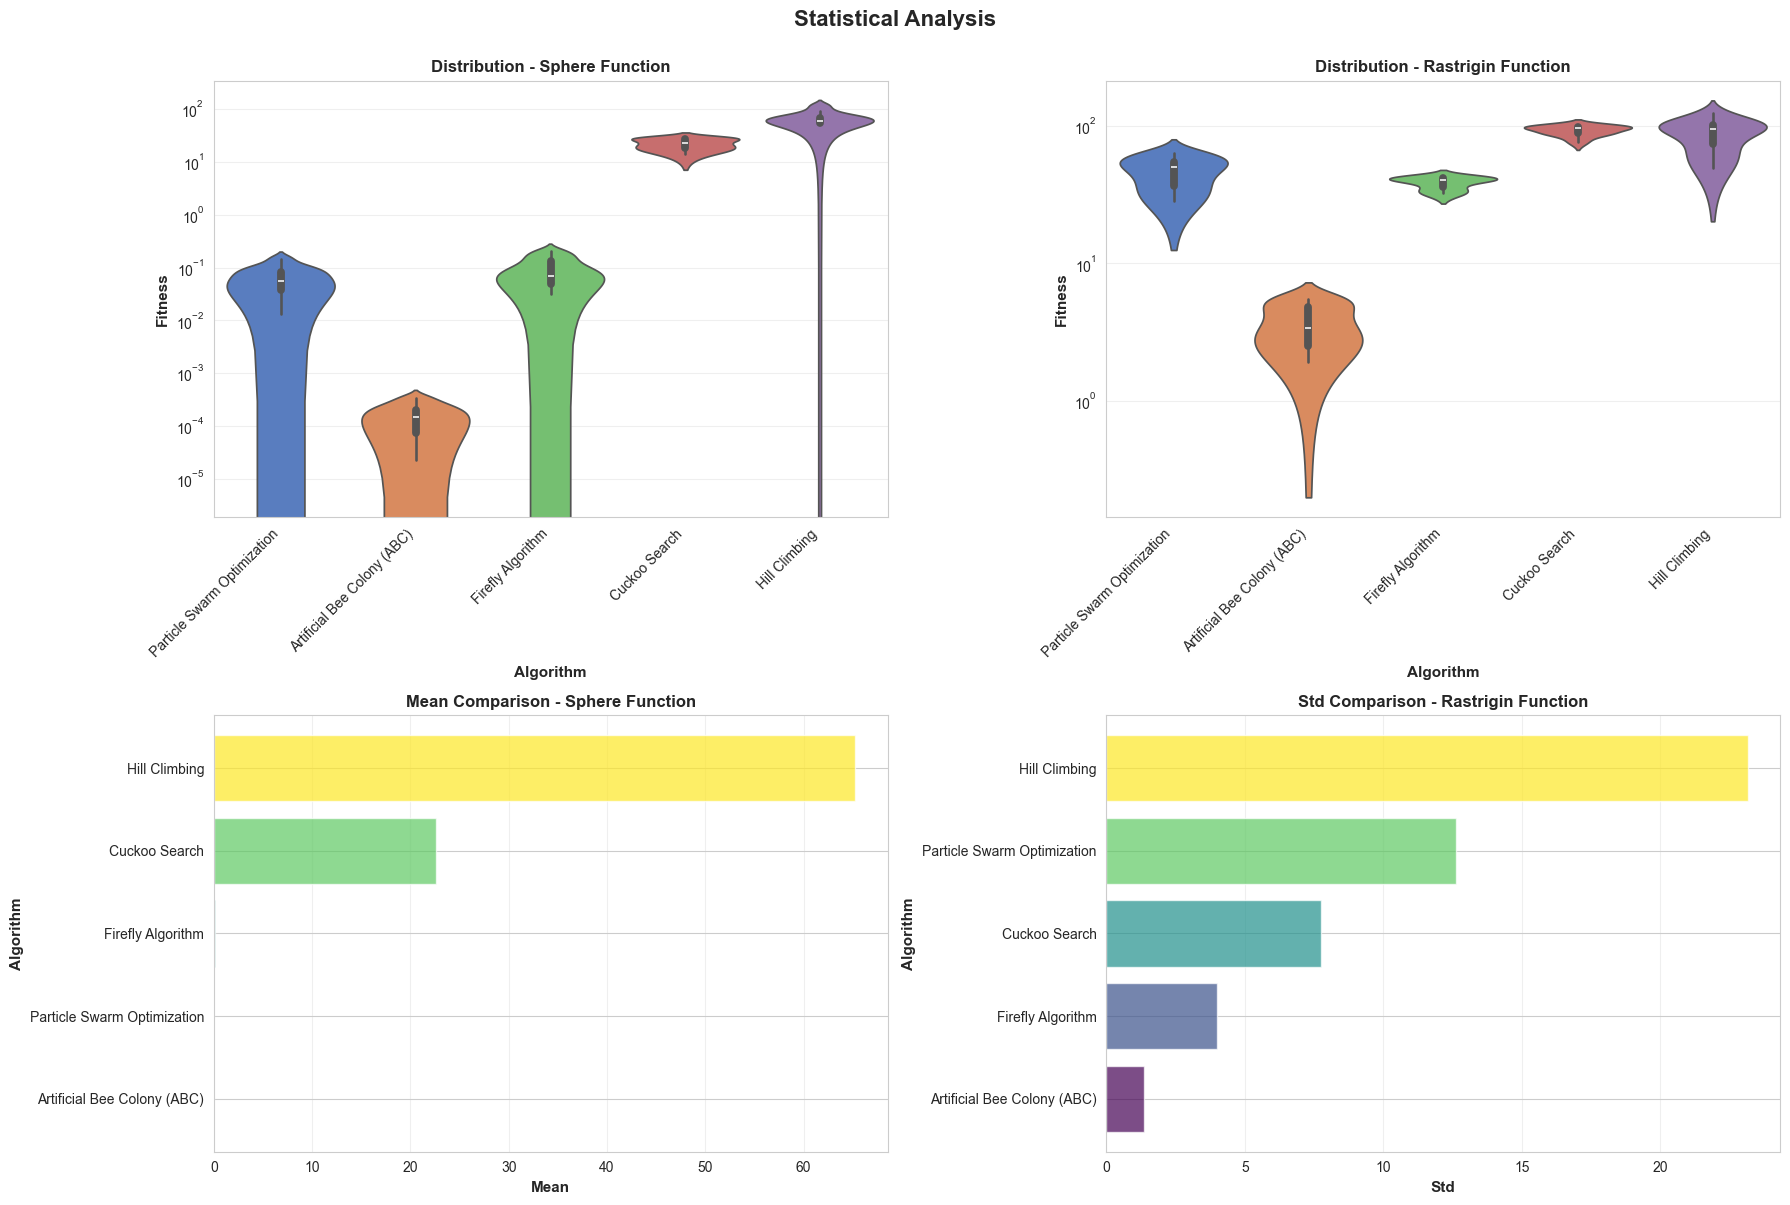


STATISTICAL SUMMARY
           Problem                   Algorithm      Mean    Median       Std    CV (%)
   Sphere Function Particle Swarm Optimization  0.063714  0.054700  0.040202 63.098359
   Sphere Function Artificial Bee Colony (ABC)  0.000151  0.000147  0.000103 68.002635
   Sphere Function           Firefly Algorithm  0.093593  0.069862  0.058186 62.169577
   Sphere Function               Cuckoo Search 22.588552 22.534456  5.492925 24.317295
   Sphere Function               Hill Climbing 65.262307 60.375641 23.711679 36.332886
Rastrigin Function Particle Swarm Optimization 46.726511 49.720136 12.633426 27.036955
Rastrigin Function Artificial Bee Colony (ABC)  3.694917  3.409553  1.369441 37.062834
Rastrigin Function           Firefly Algorithm 38.654146 40.319948  3.983993 10.306768
Rastrigin Function               Cuckoo Search 92.518693 95.632355  7.755087  8.382184
Rastrigin Function               Hill Climbing 88.088636 94.460095 23.154670 26.285650
   Ackley Function Par

In [14]:
def plot_statistical_analysis(results):
    """
    Phân tích thống kê chi tiết về performance
    """
    if not results:
        print("Không có dữ liệu để phân tích")
        return
    
    # Chuẩn bị dữ liệu
    data = []
    for problem, algorithms in results.items():
        for alg_name, alg_data in algorithms.items():
            if 'all_values' in alg_data['fitness']:
                for value in alg_data['fitness']['all_values']:
                    data.append({
                        'Problem': problem,
                        'Algorithm': alg_name,
                        'Fitness': value
                    })
    
    df = pd.DataFrame(data)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Violin plot
    problems = df['Problem'].unique()
    for idx, problem in enumerate(problems[:2]):
        problem_df = df[df['Problem'] == problem]
        
        sns.violinplot(data=problem_df, x='Algorithm', y='Fitness', 
                      ax=axes[0, idx], palette='muted', inner='box')
        
        axes[0, idx].set_title(f'Distribution - {problem}', fontsize=12, fontweight='bold')
        axes[0, idx].set_xlabel('Algorithm', fontsize=11, fontweight='bold')
        axes[0, idx].set_ylabel('Fitness', fontsize=11, fontweight='bold')
        axes[0, idx].tick_params(axis='x', rotation=45)
        axes[0, idx].grid(True, alpha=0.3, axis='y')
        axes[0, idx].set_yscale('log')
        
        # Rotate labels
        labels = axes[0, idx].get_xticklabels()
        axes[0, idx].set_xticklabels(labels, rotation=45, ha='right')
    
    # 2. Statistical comparison table
    stats_data = []
    for problem in df['Problem'].unique():
        for alg in df[df['Problem'] == problem]['Algorithm'].unique():
            alg_data = df[(df['Problem'] == problem) & (df['Algorithm'] == alg)]['Fitness']
            
            stats_data.append({
                'Problem': problem,
                'Algorithm': alg,
                'Mean': alg_data.mean(),
                'Median': alg_data.median(),
                'Std': alg_data.std(),
                'CV (%)': (alg_data.std() / alg_data.mean() * 100) if alg_data.mean() > 0 else 0
            })
    
    stats_df = pd.DataFrame(stats_data)
    
    # Vẽ comparison chart
    for idx, metric in enumerate(['Mean', 'Std']):
        problem = problems[idx] if idx < len(problems) else problems[0]
        problem_stats = stats_df[stats_df['Problem'] == problem].sort_values(metric)
        
        axes[1, idx].barh(problem_stats['Algorithm'], problem_stats[metric], 
                         alpha=0.7, color=plt.cm.viridis(np.linspace(0, 1, len(problem_stats))))
        axes[1, idx].set_xlabel(metric, fontsize=11, fontweight='bold')
        axes[1, idx].set_ylabel('Algorithm', fontsize=11, fontweight='bold')
        axes[1, idx].set_title(f'{metric} Comparison - {problem}', fontsize=12, fontweight='bold')
        axes[1, idx].grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Statistical Analysis', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    # In statistical summary
    print("\n" + "="*100)
    print("STATISTICAL SUMMARY")
    print("="*100)
    print(stats_df.to_string(index=False))
    print("="*100)

if continuous_results:
    plot_statistical_analysis(continuous_results)

# 6. Phân Tích Kết Quả Bài Toán Rời Rạc (Discrete Problems Analysis)

Phân tích kết quả cho các bài toán rời rạc như TSP.

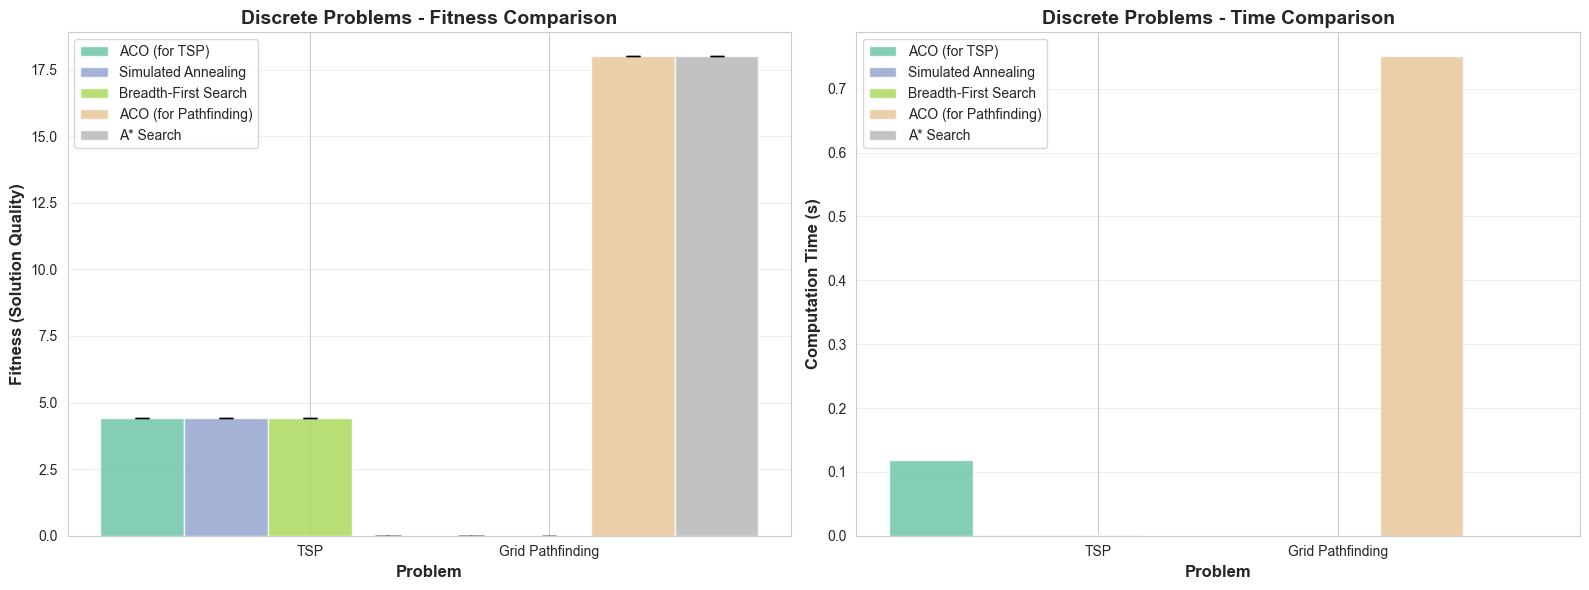


DISCRETE PROBLEMS SUMMARY
         Problem             Algorithm  Best Fitness  Mean Fitness          Std     Time
             TSP         ACO (for TSP)      4.414214      4.414214 8.881784e-16 0.118155
             TSP   Simulated Annealing      4.414214      4.414214 8.881784e-16 0.001666
             TSP  Breadth-First Search      4.414214      4.414214 8.881784e-16 0.001612
Grid Pathfinding ACO (for Pathfinding)     18.000000     18.000000 0.000000e+00 0.750767
Grid Pathfinding             A* Search     18.000000     18.000000 0.000000e+00 0.000000


In [15]:
def plot_discrete_results_comparison(results):
    """
    So sánh kết quả của các thuật toán cho bài toán rời rạc
    """
    if not results:
        print("Không có dữ liệu rời rạc để vẽ")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Chuẩn bị dữ liệu
    data = []
    for problem, algorithms in results.items():
        for alg_name, alg_data in algorithms.items():
            data.append({
                'Problem': problem,
                'Algorithm': alg_name,
                'Best Fitness': alg_data['fitness']['min'],
                'Mean Fitness': alg_data['fitness']['mean'],
                'Std': alg_data['fitness']['std'],
                'Time': alg_data['time']['mean']
            })
    
    df = pd.DataFrame(data)
    
    # 1. Fitness comparison
    problems = df['Problem'].unique()
    x = np.arange(len(problems))
    width = 0.35
    
    algorithms = df['Algorithm'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(algorithms)))
    
    for idx, alg in enumerate(algorithms):
        alg_data = df[df['Algorithm'] == alg]
        means = [alg_data[alg_data['Problem'] == p]['Mean Fitness'].values[0] 
                if len(alg_data[alg_data['Problem'] == p]) > 0 else 0 
                for p in problems]
        stds = [alg_data[alg_data['Problem'] == p]['Std'].values[0] 
               if len(alg_data[alg_data['Problem'] == p]) > 0 else 0 
               for p in problems]
        
        axes[0].bar(x + idx * width, means, width, yerr=stds,
                   label=alg, alpha=0.8, color=colors[idx], capsize=5)
    
    axes[0].set_xlabel('Problem', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Fitness (Solution Quality)', fontsize=12, fontweight='bold')
    axes[0].set_title('Discrete Problems - Fitness Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width * (len(algorithms) - 1) / 2)
    axes[0].set_xticklabels(problems, rotation=0)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 2. Time comparison
    for idx, alg in enumerate(algorithms):
        alg_data = df[df['Algorithm'] == alg]
        times = [alg_data[alg_data['Problem'] == p]['Time'].values[0] 
                if len(alg_data[alg_data['Problem'] == p]) > 0 else 0 
                for p in problems]
        
        axes[1].bar(x + idx * width, times, width,
                   label=alg, alpha=0.8, color=colors[idx])
    
    axes[1].set_xlabel('Problem', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Computation Time (s)', fontsize=12, fontweight='bold')
    axes[1].set_title('Discrete Problems - Time Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x + width * (len(algorithms) - 1) / 2)
    axes[1].set_xticklabels(problems, rotation=0)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # In summary
    print("\n" + "="*80)
    print("DISCRETE PROBLEMS SUMMARY")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)

if discrete_results:
    plot_discrete_results_comparison(discrete_results)

# 7. Tổng Kết và Kết Luận (Summary & Conclusions)

Tổng hợp insights và đưa ra kết luận về hiệu suất của các thuật toán.

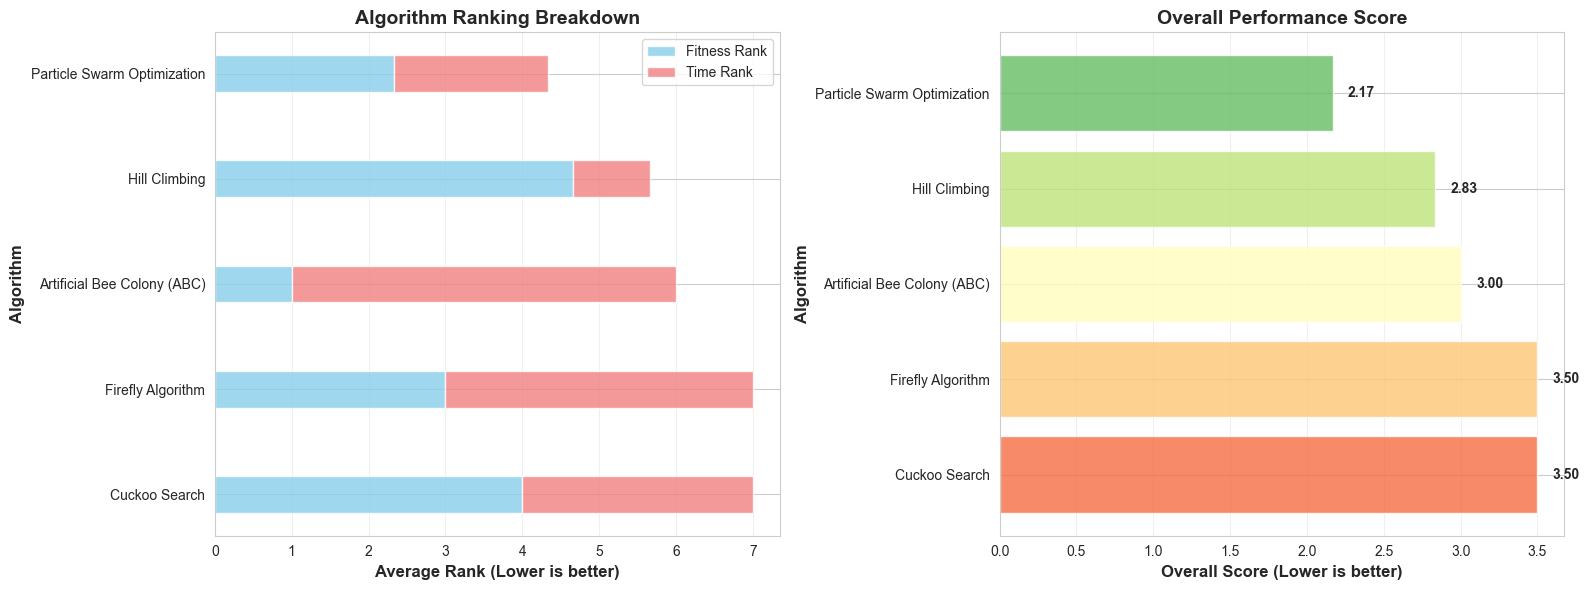


FINAL ALGORITHM RANKINGS
Rank   Algorithm                                Fitness Rank    Time Rank       Overall Score  
--------------------------------------------------------------------------------
1      Particle Swarm Optimization              2.33            2.00            2.17           
2      Hill Climbing                            4.67            1.00            2.83           
3      Artificial Bee Colony (ABC)              1.00            5.00            3.00           
4      Firefly Algorithm                        3.00            4.00            3.50           
5      Cuckoo Search                            4.00            3.00            3.50           

📊 KEY INSIGHTS:
🥇 Best Overall: Particle Swarm Optimization
⚡ Fastest: Hill Climbing
🎯 Most Accurate: Artificial Bee Colony (ABC)


In [16]:
def generate_final_rankings(results):
    """
    Tạo bảng xếp hạng tổng hợp các thuật toán
    """
    if not results:
        print("Không có dữ liệu để xếp hạng")
        return
    
    # Tính điểm cho từng thuật toán
    rankings = {}
    
    for problem, algorithms in results.items():
        # Lấy fitness values
        fitness_values = [(alg, data['fitness']['mean']) for alg, data in algorithms.items()]
        fitness_values.sort(key=lambda x: x[1])
        
        # Lấy time values
        time_values = [(alg, data['time']['mean']) for alg, data in algorithms.items()]
        time_values.sort(key=lambda x: x[1])
        
        # Tính điểm ranking (1 = tốt nhất)
        for rank, (alg, _) in enumerate(fitness_values, 1):
            if alg not in rankings:
                rankings[alg] = {'fitness_rank': 0, 'time_rank': 0, 'count': 0}
            rankings[alg]['fitness_rank'] += rank
            rankings[alg]['count'] += 1
        
        for rank, (alg, _) in enumerate(time_values, 1):
            rankings[alg]['time_rank'] += rank
    
    # Tính average rank
    for alg in rankings:
        count = rankings[alg]['count']
        rankings[alg]['avg_fitness_rank'] = rankings[alg]['fitness_rank'] / count
        rankings[alg]['avg_time_rank'] = rankings[alg]['time_rank'] / count
        rankings[alg]['overall_score'] = (rankings[alg]['avg_fitness_rank'] + 
                                         rankings[alg]['avg_time_rank']) / 2
    
    # Tạo DataFrame
    ranking_data = []
    for alg, scores in rankings.items():
        ranking_data.append({
            'Algorithm': alg,
            'Avg Fitness Rank': scores['avg_fitness_rank'],
            'Avg Time Rank': scores['avg_time_rank'],
            'Overall Score': scores['overall_score']
        })
    
    df = pd.DataFrame(ranking_data).sort_values('Overall Score')
    
    # Vẽ biểu đồ
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Ranking comparison
    x = np.arange(len(df))
    width = 0.35
    
    axes[0].barh(df['Algorithm'], df['Avg Fitness Rank'], width, 
                label='Fitness Rank', alpha=0.8, color='skyblue')
    axes[0].barh(df['Algorithm'], df['Avg Time Rank'], width, 
                left=df['Avg Fitness Rank'], label='Time Rank', alpha=0.8, color='lightcoral')
    
    axes[0].set_xlabel('Average Rank (Lower is better)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    axes[0].set_title('Algorithm Ranking Breakdown', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()
    
    # 2. Overall score
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(df)))
    bars = axes[1].barh(df['Algorithm'], df['Overall Score'], alpha=0.8, color=colors)
    
    axes[1].set_xlabel('Overall Score (Lower is better)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    axes[1].set_title('Overall Performance Score', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    axes[1].invert_yaxis()
    
    # Add value labels
    for i, (idx, row) in enumerate(df.iterrows()):
        axes[1].text(row['Overall Score'] + 0.1, i, f"{row['Overall Score']:.2f}", 
                    va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # In bảng xếp hạng
    print("\n" + "="*80)
    print("FINAL ALGORITHM RANKINGS")
    print("="*80)
    print(f"{'Rank':<6} {'Algorithm':<40} {'Fitness Rank':<15} {'Time Rank':<15} {'Overall Score':<15}")
    print("-"*80)
    for idx, (_, row) in enumerate(df.iterrows(), 1):
        print(f"{idx:<6} {row['Algorithm']:<40} {row['Avg Fitness Rank']:<15.2f} "
              f"{row['Avg Time Rank']:<15.2f} {row['Overall Score']:<15.2f}")
    print("="*80)
    
    # Thêm insights
    print("\n📊 KEY INSIGHTS:")
    print(f"🥇 Best Overall: {df.iloc[0]['Algorithm']}")
    print(f"⚡ Fastest: {df.sort_values('Avg Time Rank').iloc[0]['Algorithm']}")
    print(f"🎯 Most Accurate: {df.sort_values('Avg Fitness Rank').iloc[0]['Algorithm']}")
    
    return df

if continuous_results:
    final_rankings = generate_final_rankings(continuous_results)

---

## 🎯 Hướng Dẫn Sử Dụng Notebook

Notebook này cung cấp hệ thống phân tích và trực quan hóa toàn diện cho các bài toán tối ưu hóa:

### 📋 Các Phần Chính:

1. **Khả Năng Hội Tụ (Convergence Behavior)**
   - Biểu đồ convergence curves cho từng thuật toán
   - So sánh tốc độ hội tụ giữa các thuật toán

2. **Hiệu Suất So Sánh (Performance Comparison)**
   - So sánh fitness, time, evaluations
   - Boxplot phân tích phân phối
   - Radar chart đa chiều
   - Heatmap so sánh

3. **Phân Tích Độ Nhạy Tham Số (Parameter Sensitivity)**
   - Ảnh hưởng của số lần evaluations
   - Trade-off giữa quality và time
   - Efficiency score
   - Convergence rate analysis

4. **Biểu Đồ Bề Mặt 3D (3D Surface Visualization)**
   - Surface plots của các hàm benchmark
   - Multi-view visualization
   - Gradient field visualization
   - Contour plots

5. **Phân Tích Tổng Hợp (Comprehensive Analysis)**
   - Statistical summary
   - Comprehensive comparison tables
   - Violin plots
   - Final rankings

### 💡 Cách Sử Dụng:

1. Chạy tất cả các cells từ đầu đến cuối (Run All)
2. Xem các biểu đồ và phân tích được tạo ra
3. Có thể tùy chỉnh các tham số trong các hàm để phân tích chi tiết hơn

### 📊 Outputs:

- Biểu đồ trực quan hóa đa dạng
- Bảng so sánh chi tiết
- Statistical summaries
- Rankings và insights

---